# Denoise data

Majid reached out for aid in denoising some data he came across:

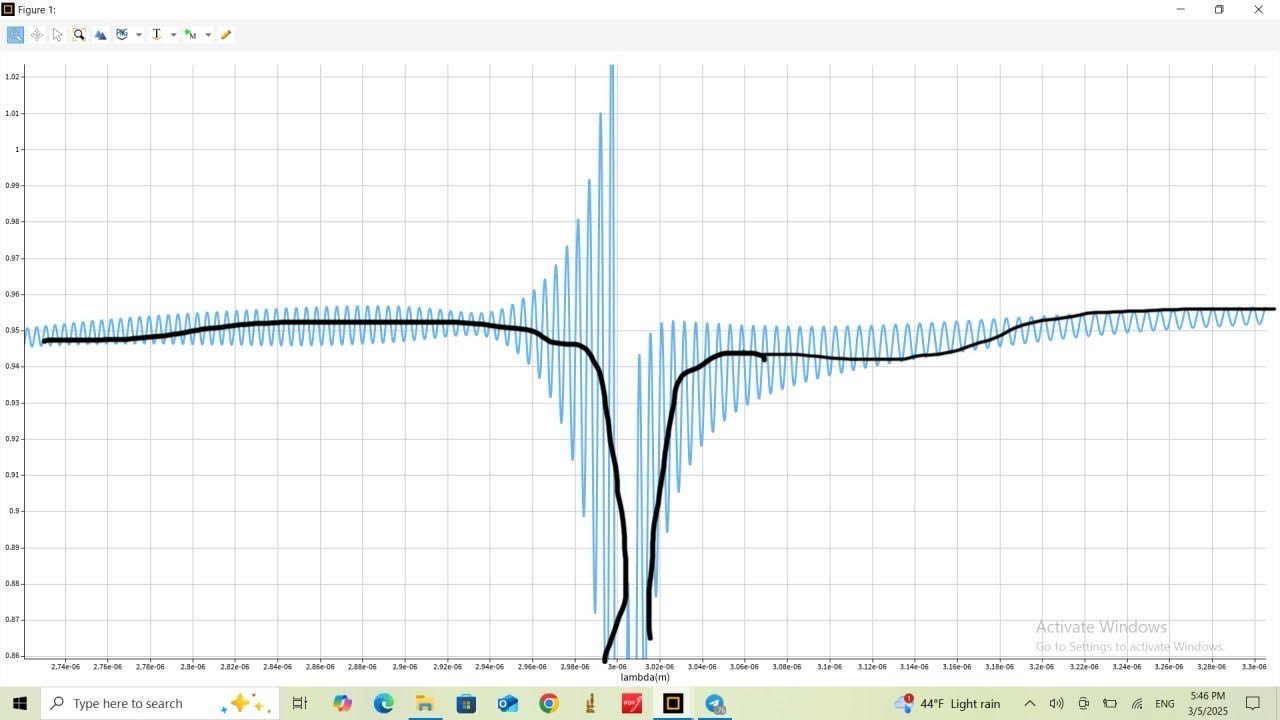

The blue line is the data and the black line is what he wants the data to look like after denoising

In [384]:
import pandas as pd
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt
# from skimage.restoration import denoise_nl_means, estimate_sigma
# from skimage import img_as_float
from skimage.restoration import denoise_bilateral
from skimage.restoration import denoise_tv_chambolle
from skimage.restoration import denoise_tv_bregman
import numpy as np
import os
import shutil
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

from collections import defaultdict, Counter, deque

In [2]:
# read the data in from the xlsx file
df = pd.read_excel('p2000-base1200-h2000_TE.xlsx')
# set the columns to be lambda and signal
df.columns = ['lambda', 'signal']

In [3]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 10002  │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━┳━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column ┃ NA ┃ NA %        ┃ mean    ┃ sd        ┃ p0       ┃ p25     ┃ p50     ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━╇━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ lambda │  2 │ 0.019996000 │ 2.8e-06 │ 1.386e-06 │    4e-07 │ 1.6e-06 │ 2.8e-06 │  4e-06 │ 5.2e-06 │ ▇▇▇▇▇▇ │  │
│ │        │    │    79984003 │         │           │          │         │         │        │         │        │  │
│ │ signal │  2 │ 0.019996000 │  0.7296 │    0.2715 │ 0.005539 │  0.4355 │  0.8775 │ 0.9339 │  0.9763 │  ▂▁ ▁▇ │  │
│ │        │    │    79984003 │         │           │          │         │         │        │         │        │  │
│ └────────┴────┴─────────────┴─────────┴───────────┴──────────┴─────────┴─────────┴────────┴─────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [4]:
df_no_na = pd.DataFrame(df.dropna(how="any"))

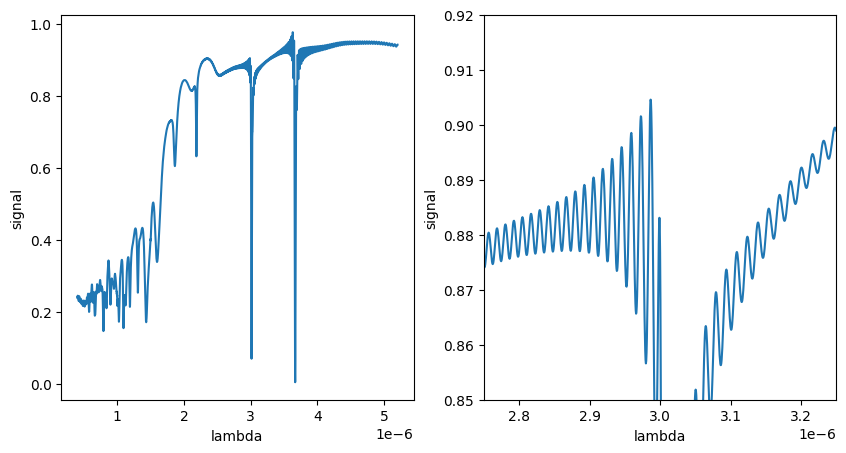

In [5]:
# first plot a line plot of the data
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0])
# second plot is a zoomed in version of the first plot at lambda between (2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1])
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

In [6]:
# now let's try to smooth the signal column using a rolling window
df_no_na['smoothed_signal_rw50'] = df_no_na['signal'].rolling(window=30).mean()
# now try lowess smoothing

# Savitzky-Golay filter
df_no_na['smoothed_signal_sg'] = savgol_filter(df_no_na['signal'], window_length=101, polyorder=3)

# Wavelet Transform
coeffs = pywt.wavedec(df_no_na['signal'], 'db1', level=2)
sigma = (1/0.6745) * np.median(np.abs(coeffs[-1] - np.median(coeffs[-1])))
uthresh = sigma * np.sqrt(2 * np.log(len(df_no_na['signal'])))
denoised_coeffs = list(map(lambda x: pywt.threshold(x, value=uthresh, mode='soft'), coeffs))
df_no_na['smoothed_signal_wavelet'] = pywt.waverec(denoised_coeffs, 'db1')

# Bilateral Filter
df_no_na['smoothed_signal_bilateral'] = denoise_bilateral(df_no_na['signal'], sigma_color=0.05, sigma_spatial=15)

# Total Variation Denoising
df_no_na['smoothed_signal_tv'] = denoise_tv_chambolle(df_no_na['signal'], weight=1.0)


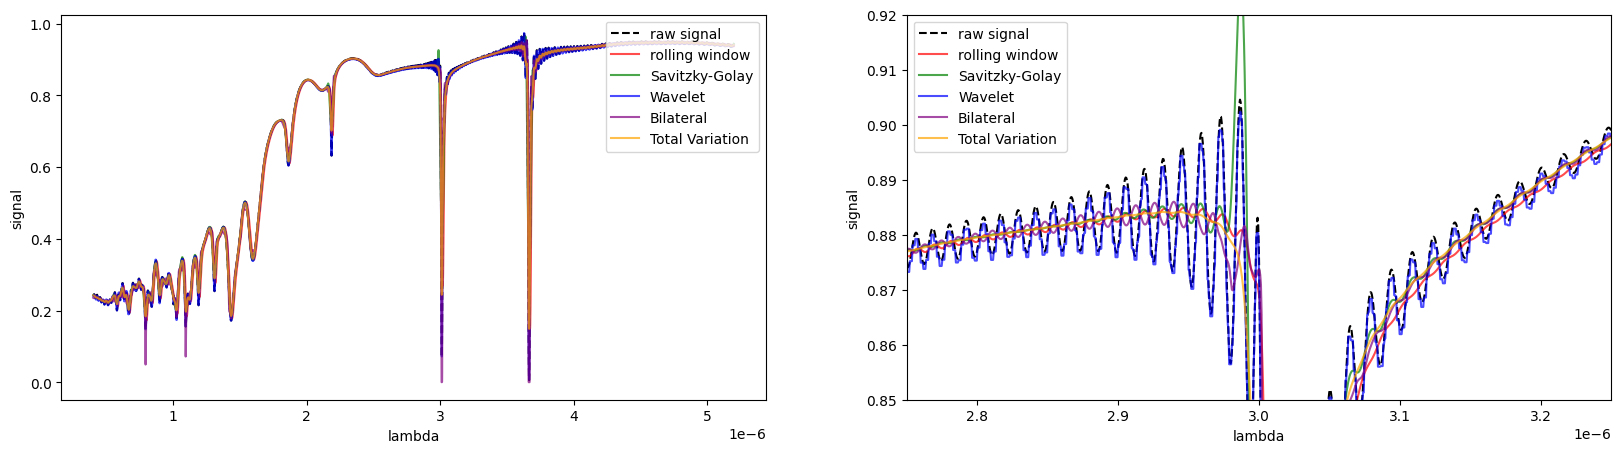

In [7]:
# first plot a line plot of the data
alph = 0.7

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_rw50', data=df_no_na, ax=ax[0], color='red',label='rolling window', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_sg', data=df_no_na, ax=ax[0], color='green',label='Savitzky-Golay', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_wavelet', data=df_no_na, ax=ax[0], color='blue',label='Wavelet', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_bilateral', data=df_no_na, ax=ax[0], color='purple',label='Bilateral', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_tv', data=df_no_na, ax=ax[0], color='orange',label='Total Variation', alpha=alph)
ax[0].legend(loc='upper right')
# second plot is a zoomed in version of the first plot at lambda between (2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_rw50', data=df_no_na, ax=ax[1], color='red',label='rolling window', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_sg', data=df_no_na, ax=ax[1], color='green',label='Savitzky-Golay', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_wavelet', data=df_no_na, ax=ax[1], color='blue',label='Wavelet', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_bilateral', data=df_no_na, ax=ax[1], color='purple',label='Bilateral', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_tv', data=df_no_na, ax=ax[1], color='orange',label='Total Variation', alpha=alph)
ax[0].legend(loc='upper right')    
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

I think total variation smoothing is the closest to what I'm trying to achieve.

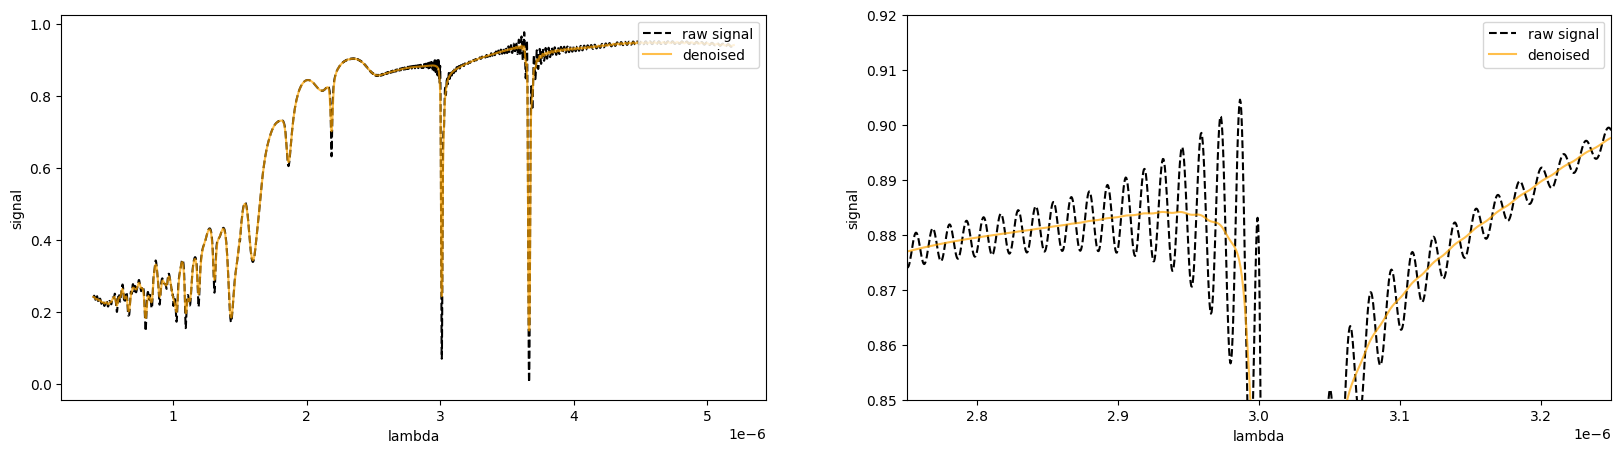

In [8]:
# first plot a line plot of the data
alph = 0.7

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y='smoothed_signal_rw50', data=df_no_na, ax=ax[0], color='red',label='rolling window', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_sg', data=df_no_na, ax=ax[0], color='green',label='Savitzky-Golay', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_wavelet', data=df_no_na, ax=ax[0], color='blue',label='Wavelet', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_bilateral', data=df_no_na, ax=ax[0], color='purple',label='Bilateral', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_tv', data=df_no_na, ax=ax[0], color='orange',label='denoised', alpha=alph)
ax[0].legend(loc='upper right')
# second plot is a zoomed in version of the first plot at lambda between (2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y='smoothed_signal_rw50', data=df_no_na, ax=ax[1], color='red',label='rolling window', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_sg', data=df_no_na, ax=ax[1], color='green',label='Savitzky-Golay', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_wavelet', data=df_no_na, ax=ax[1], color='blue',label='Wavelet', alpha=alph)
# sns.lineplot(x='lambda', y='smoothed_signal_bilateral', data=df_no_na, ax=ax[1], color='purple',label='Bilateral', alpha=alph)
sns.lineplot(x='lambda', y='smoothed_signal_tv', data=df_no_na, ax=ax[1], color='orange',label='denoised', alpha=alph)
ax[0].legend(loc='upper right')    
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

Yeah, now just to be sure I want to try different weights for the total variation smoothing.

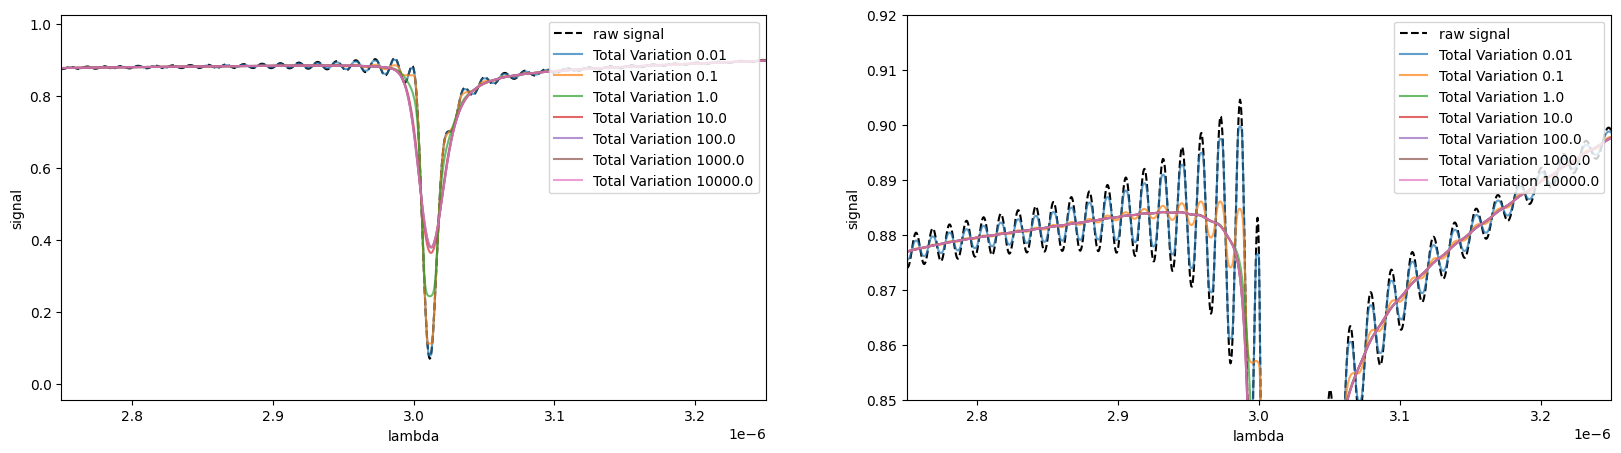

In [9]:
tws = [0.01,0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
for tw in tws:
    # Total Variation Denoising
    df_no_na[f'smoothed_signal_tv_{tw}'] = denoise_tv_chambolle(df_no_na['signal'], weight=tw)
    
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
for tw in tws:
    sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{tw}', data=df_no_na, ax=ax[0],label=f'Total Variation {tw}', alpha=alph)
ax[0].legend(loc='upper right')
ax[0].set_xlim(2.75e-6, 3.25e-6)
# second plot is a zoomed in version of the first plot at lambda between (2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
for tw in tws:
    sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{tw}', data=df_no_na, ax=ax[1],label=f'Total Variation {tw}', alpha=alph)
ax[1].legend(loc='upper right')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

ok so there is a trade-off with local minima preservation vs "wiggle smoothing". Ideally, would prefer something in-between the orange and green lines.

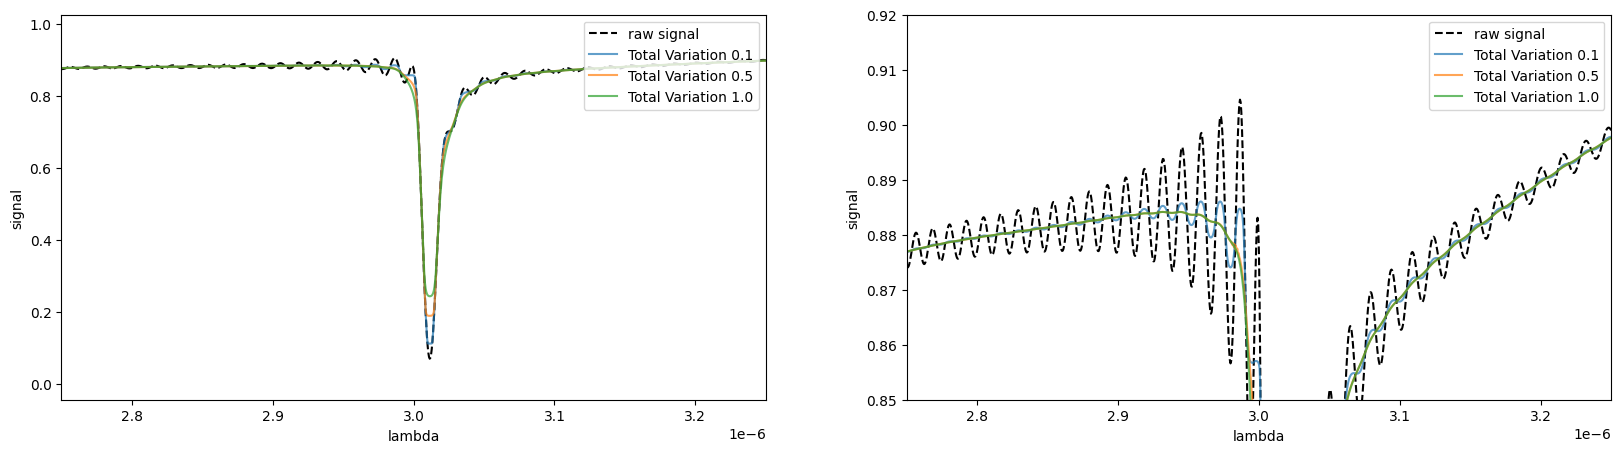

In [10]:
tws = [0.1, 0.5 ,1.0]
for tw in tws:
    # Total Variation Denoising
    df_no_na[f'smoothed_signal_tv_{tw}'] = denoise_tv_chambolle(df_no_na['signal'], weight=tw)
    
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
for tw in tws:
    sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{tw}', data=df_no_na, ax=ax[0],label=f'Total Variation {tw}', alpha=alph)
ax[0].legend(loc='upper right')
ax[0].set_xlim(2.75e-6, 3.25e-6)
# second plot is a zoomed in version of the first plot at lambda between (2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
for tw in tws:
    sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{tw}', data=df_no_na, ax=ax[1],label=f'Total Variation {tw}', alpha=alph)
ax[1].legend(loc='upper right')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

eh, total variation smoothing with 0.5 as the weight looks good to me, time to save and send it

In [11]:
final_smoothed = df.merge(df_no_na[["smoothed_signal_tv_0.5"]], left_index=True, right_index=True, how="left")
final_smoothed

lambda    signal  smoothed_signal_tv_0.5
0               NaN       NaN                     NaN
1               NaN       NaN                     NaN
2      4.000000e-07  0.240174                0.242257
3      4.004800e-07  0.241098                0.242250
4      4.009600e-07  0.241614                0.242237
...             ...       ...                     ...
9997   5.198080e-06  0.941626                0.940662
9998   5.198560e-06  0.941668                0.940694
9999   5.199040e-06  0.941694                0.940719
10000  5.199520e-06  0.941706                0.940736
10001  5.200000e-06  0.941702                0.940744

[10002 rows x 3 columns]

In [12]:
# save to xlsx format
final_smoothed.to_excel('p2000-base1200-h2000_TE_smoothed.xlsx', index=False)

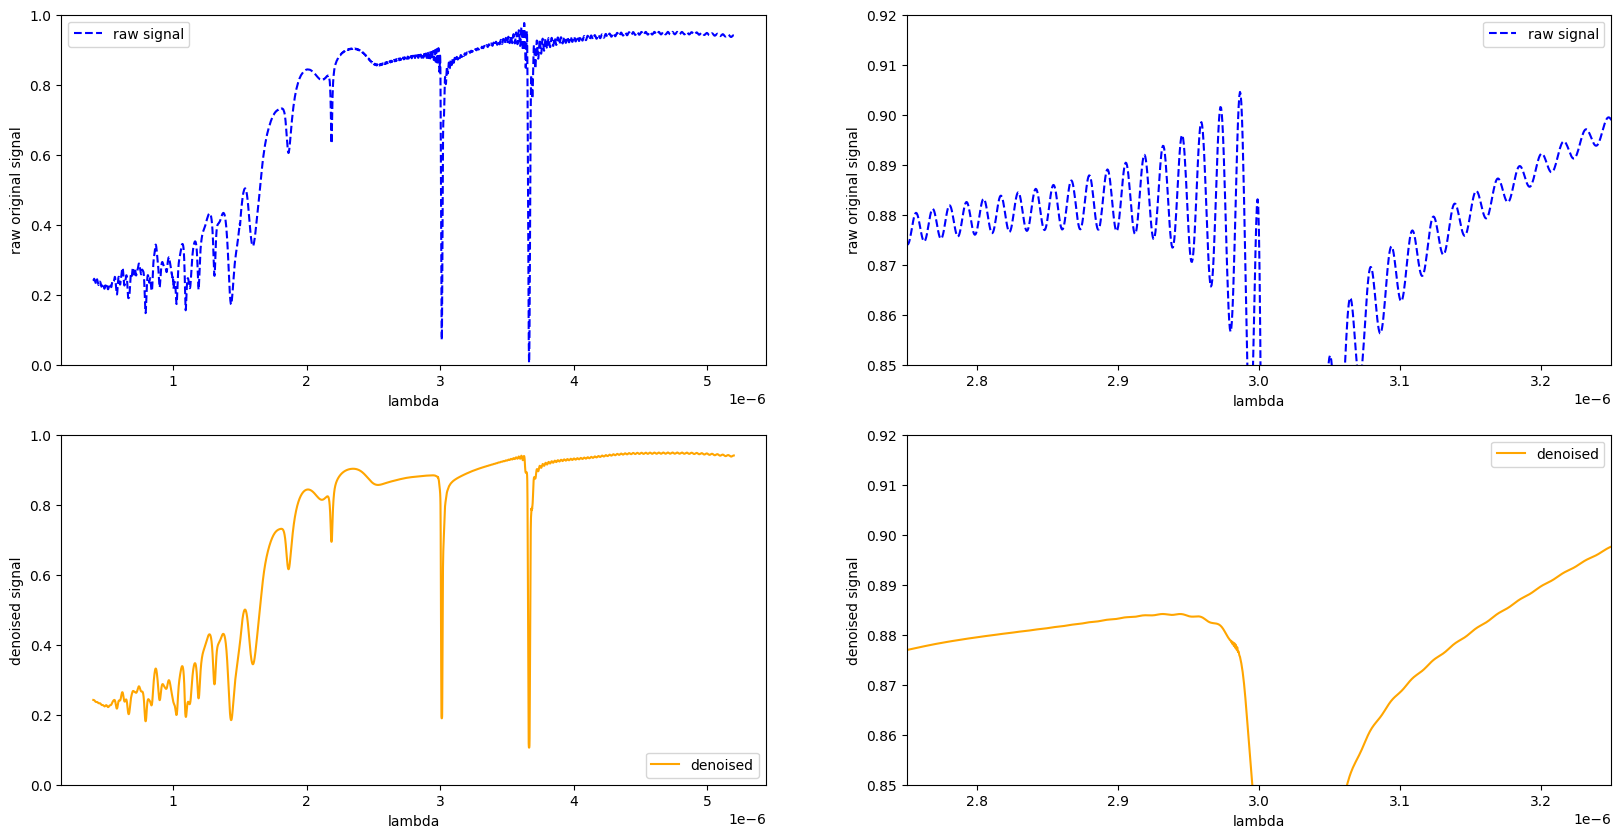

In [13]:
# create one final figure to demonstrate the smoothing

fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='blue',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_0.5', data=df_no_na, ax=ax[2], color='orange',label='denoised')
ax[0].set_ylabel('raw original signal')
ax[2].set_ylabel('denoised signal')
ax[0].set_ylim(0,1)
ax[2].legend(loc='lower right')
ax[2].set_ylim(0,1)

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='blue',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_0.5', data=df_no_na, ax=ax[3], color='orange',label='denoised')
ax[1].set_ylabel('raw original signal')
ax[3].set_ylabel('denoised signal')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
ax[3].set_xlim(2.75e-6, 3.25e-6)
ax[3].set_ylim(0.85, 0.92)
plt.show()

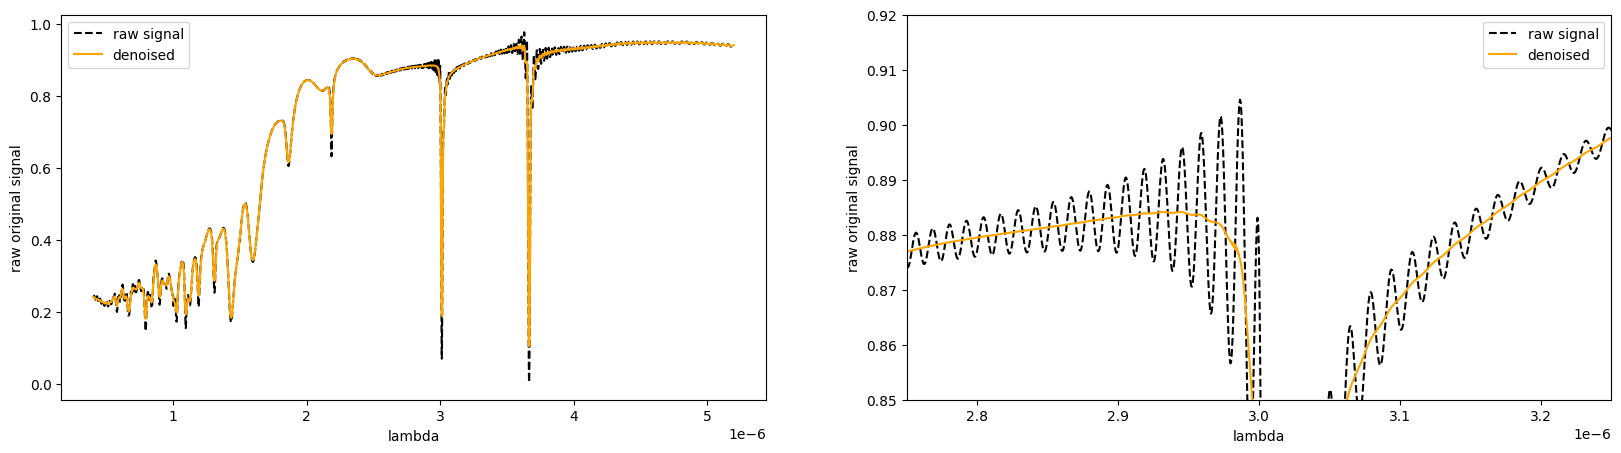

In [14]:
# create overlayed plots of the raw signal and the denoised signal

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_0.5', data=df_no_na, ax=ax[0], color='orange',label='denoised')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_0.5', data=df_no_na, ax=ax[1], color='orange',label='denoised')
ax[1].set_ylabel('raw original signal')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

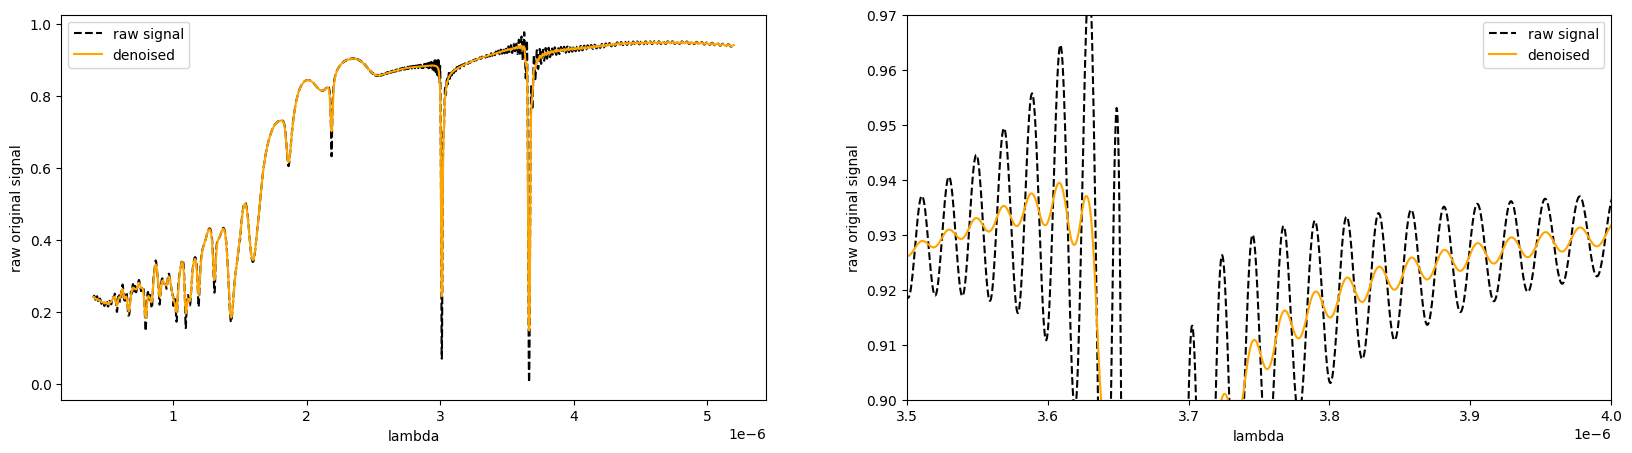

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_1.0', data=df_no_na, ax=ax[0], color='orange',label='denoised')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal_tv_1.0', data=df_no_na, ax=ax[1], color='orange',label='denoised')
ax[1].set_ylabel('raw original signal')
ax[1].set_xlim(3.5e-6, 4.00e-6)
ax[1].set_ylim(0.90, 0.97)
plt.show()

# Denoise other data

In [16]:
suffixes = ["TE_1.3","TE_1.35","TE_1.4","TE_1.45","TM_1.3","TM_1.35","TM_1.4","TM_1.45"]
new_data = {}
for suffix in suffixes:
    df = pd.read_csv(f'index_sweep/p2000-base1200-h2000_{suffix}.txt',skiprows=2)
    df.columns = ['lambda', 'signal']
    new_data[f'p2000-base1200-h2000_{suffix}'] = df

new_data[f'p2000-base1200-h2000_TE_1.3']

lambda    signal
0     4.000000e-07  0.279458
1     4.004800e-07  0.279039
2     4.009600e-07  0.278643
3     4.014400e-07  0.277925
4     4.019200e-07  0.277463
...            ...       ...
9995  5.198080e-06  0.939177
9996  5.198560e-06  0.939159
9997  5.199040e-06  0.939142
9998  5.199520e-06  0.939124
9999  5.200000e-06  0.939105

[10000 rows x 2 columns]

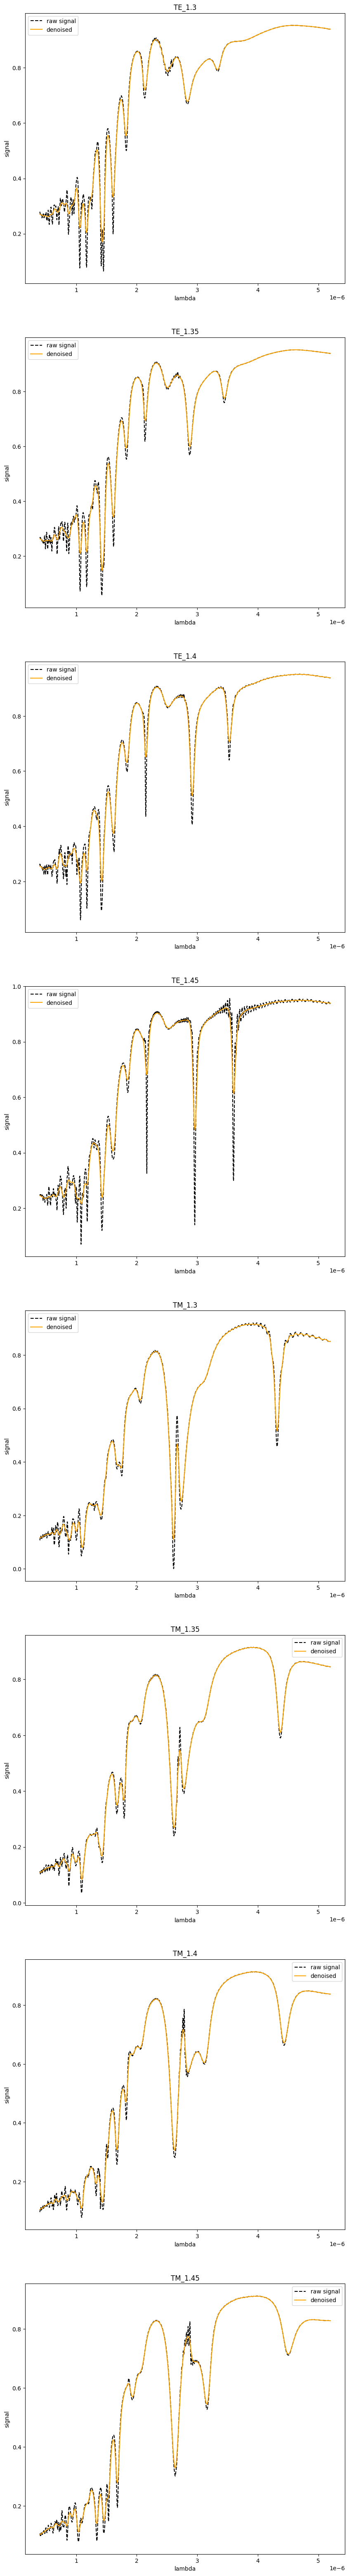

In [17]:
weight = 0.5 #100.0
niter = 1000
fig,axs = plt.subplots(8,1,figsize=(10,80))
for i,suffix in enumerate(suffixes):
    sns.lineplot(x='lambda', y='signal', data=new_data[f'p2000-base1200-h2000_{suffix}'], ax=axs[i],label="raw signal",color='black',linestyle='dashed')
    # apply the total variation denoising
    new_data[f'p2000-base1200-h2000_{suffix}'][f'smoothed_signal_tv_{weight}_{niter}'] = new_data[f'p2000-base1200-h2000_{suffix}']['signal']
    for _ in range(niter):
        new_data[f'p2000-base1200-h2000_{suffix}'][f'smoothed_signal_tv_{weight}_{niter}'] = denoise_tv_chambolle(new_data[f'p2000-base1200-h2000_{suffix}'][f'smoothed_signal_tv_{weight}_{niter}'], weight=weight)
    sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{weight}_{niter}', data=new_data[f'p2000-base1200-h2000_{suffix}'], ax=axs[i],label='denoised',color='orange')
    axs[i].set_title(suffix)
plt.show()

# save figure to svg format
fig.savefig('index_sweep/p2000-base1200-h2000_total_variation_denoising.svg')

In [18]:
# save the denoised data to txt files in a new folder
os.makedirs('index_sweep_denoised', exist_ok=True)
for suffix in suffixes:
    new_data[f'p2000-base1200-h2000_{suffix}'][["lambda","signal",f'smoothed_signal_tv_{weight}_{niter}']].to_csv(f'index_sweep_denoised/p2000-base1200-h2000_{suffix}_denoised.txt',index=False)

# copy the svg file to the new folder
shutil.copy('index_sweep/p2000-base1200-h2000_total_variation_denoising.svg', 'index_sweep_denoised/')

# compress the folder using zip
shutil.make_archive('index_sweep_denoised', 'zip', 'index_sweep_denoised')

'c:\\Users\\craut\\Documents\\colorimetry_ML\\code\\p03_denoising\\index_sweep_denoised.zip'

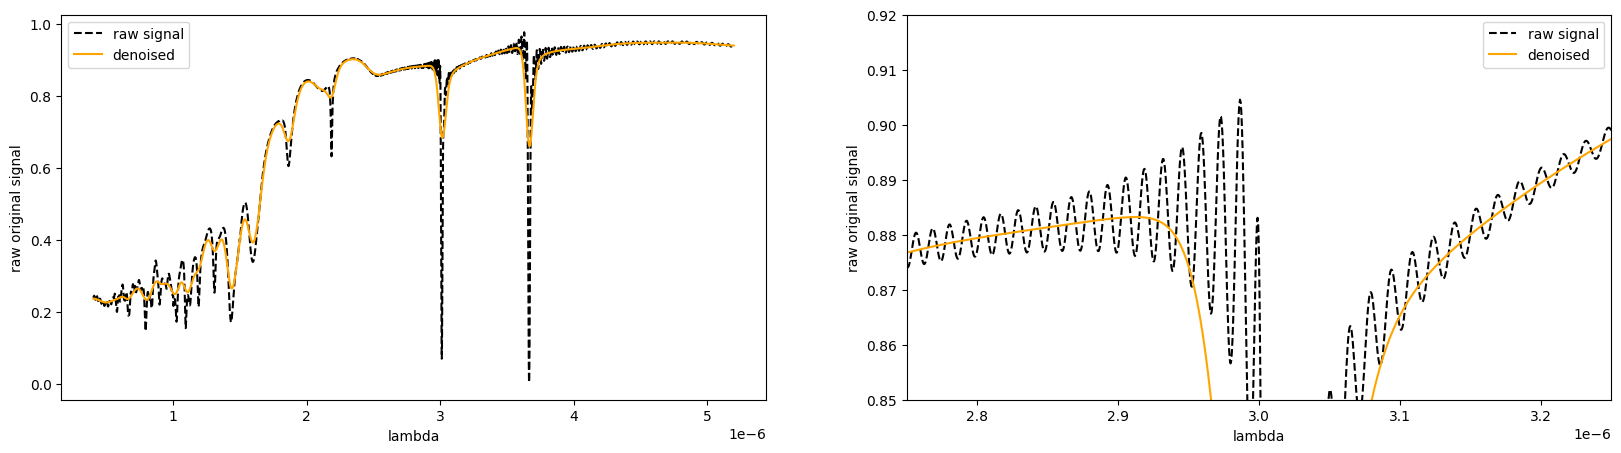

In [19]:
# now we want to reapply this denoising protocol to the original data since the parameters are a little different
df_no_na[f'smoothed_signal_tv_{weight}_{niter}'] = df_no_na['signal']
for _ in range(niter):
    df_no_na[f'smoothed_signal_tv_{weight}_{niter}'] = denoise_tv_chambolle(df_no_na[f'smoothed_signal_tv_{weight}_{niter}'], weight=weight)


# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{weight}_{niter}', data=df_no_na, ax=ax[0], color='orange',label='denoised')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{weight}_{niter}', data=df_no_na, ax=ax[1], color='orange',label='denoised')
ax[1].set_ylabel('raw original signal')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)
plt.show()

The reception to this denoising attempt was poor. The collaborator clarified that they would like to preserve the sharp drop-off at the local minima's. Furthermore, reduction of signal at the local minimas is a very bad thing according to the collaborator.

# Try a custom implementation of local total variation denoising

The trick with this approach is to try to identify the portions of the data which correspond to the local optima that we want to preserve. And we can denoise the rest of the data with total variation denoising while preserving the original trends of the local optima. We will then "stitch" together the results of the denoised data and the raw data.

In [20]:
def local_preserver_denoising(signal,size_mult_factor=3.0):
  # this is a custom denoising approach that first tries to identify all the V's in the 1D signal
  # it determines which V's are the local signals and which are the noise
  # it then applies a denoising algorithm to the noise and then restiches the signal back together

  # first we need to identify the V's in the signal
  # a V is defined as a sequence of values that are decreasing and then increasing
  # let's assume that we are always starting at the upper left of the V
  signal = np.array(signal)
  v_groups = []
  Vs = [[]]
  downward = True
  for s1,s2 in zip(signal[:-1], signal[1:]):
    v_groups.append(len(Vs)-1)
    if downward:
      Vs[-1].append(s1)
      if s1 < s2:
        downward = False
    else:
      Vs[-1].append(s1)
      if s1 > s2:
        Vs[-1].append(s2)
        Vs.append([])
        downward = True
    
  if Vs[-1] == []:
    Vs = Vs[:-1]
  v_groups.append(len(Vs)-1)
  v_groups.append(len(Vs)-1)
  Vs_length = [ len(V) for V in Vs]
  Vs_size = [ max(V) - min(V) for V in Vs]

  # now let us define the local signals as those Vs that are surrounded by Vs that are smaller in size
  local_signals = []
  for i in range(1,len(Vs)-1):
    if Vs_size[i] > size_mult_factor*Vs_size[i+1] or Vs_size[i] > size_mult_factor*Vs_size[i-1]:
      local_signals.append(i)
  #print(local_signals)

  # now we need to denoise the Vs that are not local signals
  # we will denoise using the total variation denoising
  # however we will do so in chunks of contiguous non-local signals V's
  # we do this by first building a scaffold of the non-local signals
  new_signal = signal.copy()

  scaffold = []
  scaffold_2_orig_index = []
  for i,s,g in zip(range(len(signal)), signal, v_groups):
    if g not in local_signals:
      scaffold.append(s)
      scaffold_2_orig_index.append(i)
    elif len(scaffold) != 0:
      scaffold_denoise = np.array(scaffold)
      for _ in range(niter):
        scaffold_denoise = denoise_tv_chambolle(scaffold_denoise, weight=weight)  
      for i,s in zip(scaffold_2_orig_index, scaffold_denoise):
        new_signal[i] = s
      scaffold = []
      scaffold_2_orig_index = []
    else:
      pass
  if len(scaffold) != 0:
    scaffold_denoise = np.array(scaffold)
    for _ in range(niter):
      scaffold_denoise = denoise_tv_chambolle(scaffold_denoise, weight=weight)  
    for i,s in zip(scaffold_2_orig_index, scaffold_denoise):
      new_signal[i] = s

  # Now we need to clean up the local signal locations
  # we do this by abusing the nature of the V at the local signals
  decreasing = True
  for i,s,g in zip(range(len(signal)), signal, v_groups):
    if g in local_signals:
      if decreasing:
        new_signal[i] = min(signal[i], signal[i-1])
        if signal[i] < signal[i+1]:
          decreasing = False
      else:
        new_signal[i] = min(signal[i], signal[i+1])
        if signal[i] > signal[i+1]:
          decreasing = True

  return new_signal

In [21]:
new_signal = local_preserver_denoising(df_no_na['signal'])
new_signal

array([0.24257864, 0.24257864, 0.24257864, ..., 0.93932186, 0.93932147,
       0.93932127], shape=(10000,))

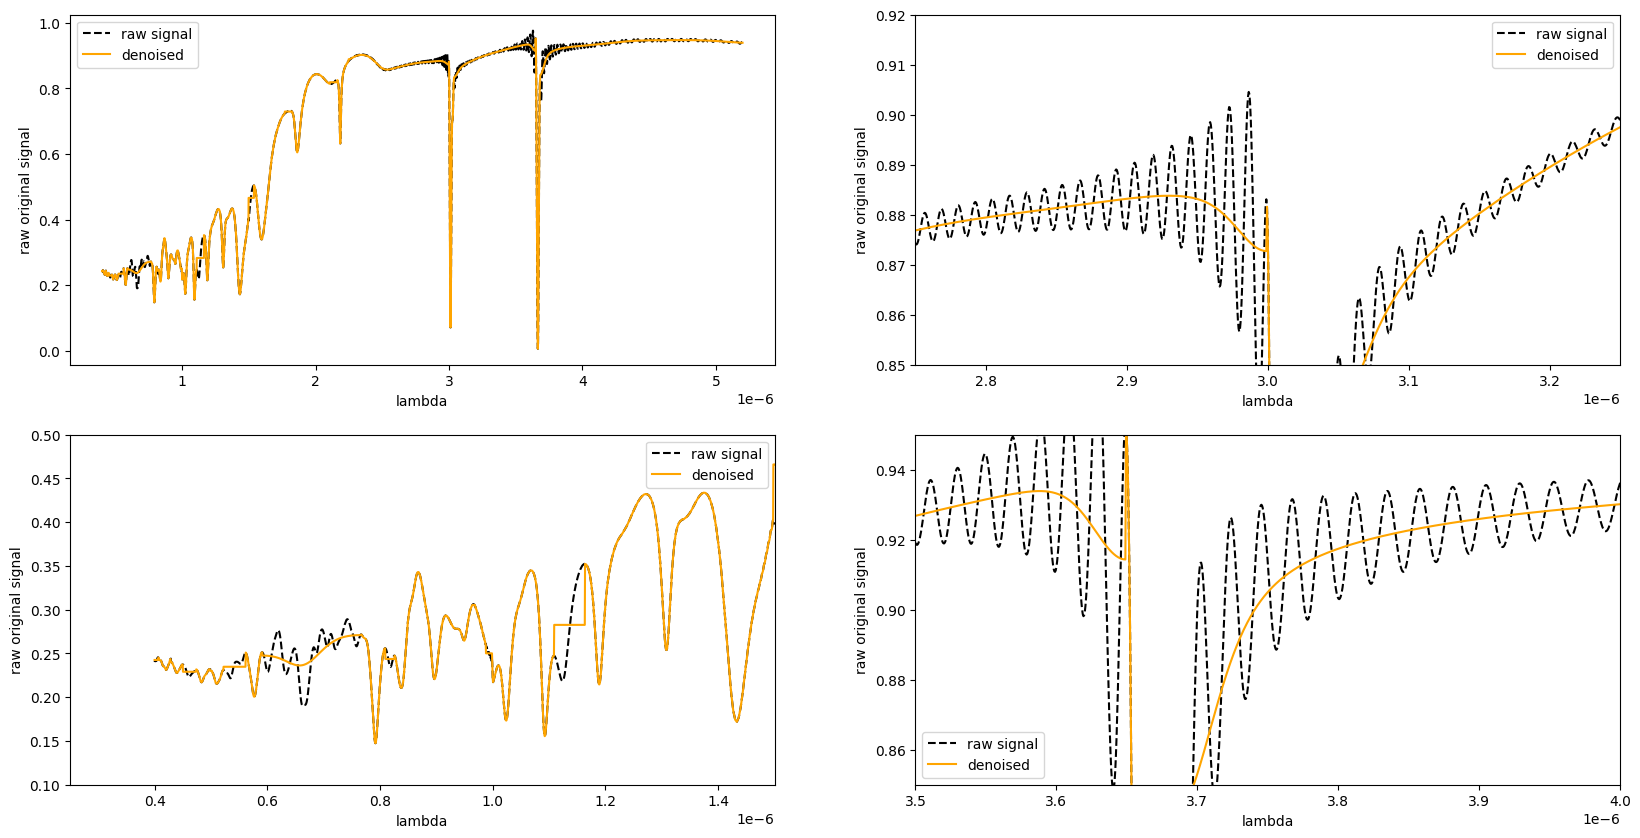

In [22]:

denoised_signal = new_signal

df_no_na['smoothed_signal_wavelet'] = denoised_signal

# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[0],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_wavelet', data=df_no_na, ax=ax[0], color='orange',label='denoised')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[1],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_wavelet', data=df_no_na, ax=ax[1], color='orange',label='denoised')
ax[1].set_ylabel('raw original signal')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[2],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_wavelet', data=df_no_na, ax=ax[2], color='orange',label='denoised')
ax[2].set_ylabel('raw original signal')
ax[2].set_xlim(0.25e-6, 1.5e-6)
ax[2].set_ylim(0.1, 0.5)

sns.lineplot(x='lambda', y='signal', data=df_no_na, ax=ax[3],label='raw signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_wavelet', data=df_no_na, ax=ax[3], color='orange',label='denoised')
ax[3].set_ylabel('raw original signal')
ax[3].set_xlim(3.5e-6, 4.0e-6)
ax[3].set_ylim(0.85, 0.95)

plt.show()

So this isn't working the way I would like it to work

In [25]:
orig_test_df = pd.DataFrame(df_no_na[["lambda","signal","smoothed_signal_tv_0.5"]])
orig_test_df

lambda    signal  smoothed_signal_tv_0.5
2      4.000000e-07  0.240174                0.242257
3      4.004800e-07  0.241098                0.242250
4      4.009600e-07  0.241614                0.242237
5      4.014400e-07  0.241734                0.242217
6      4.019200e-07  0.241592                0.242191
...             ...       ...                     ...
9997   5.198080e-06  0.941626                0.940662
9998   5.198560e-06  0.941668                0.940694
9999   5.199040e-06  0.941694                0.940719
10000  5.199520e-06  0.941706                0.940736
10001  5.200000e-06  0.941702                0.940744

[10000 rows x 3 columns]

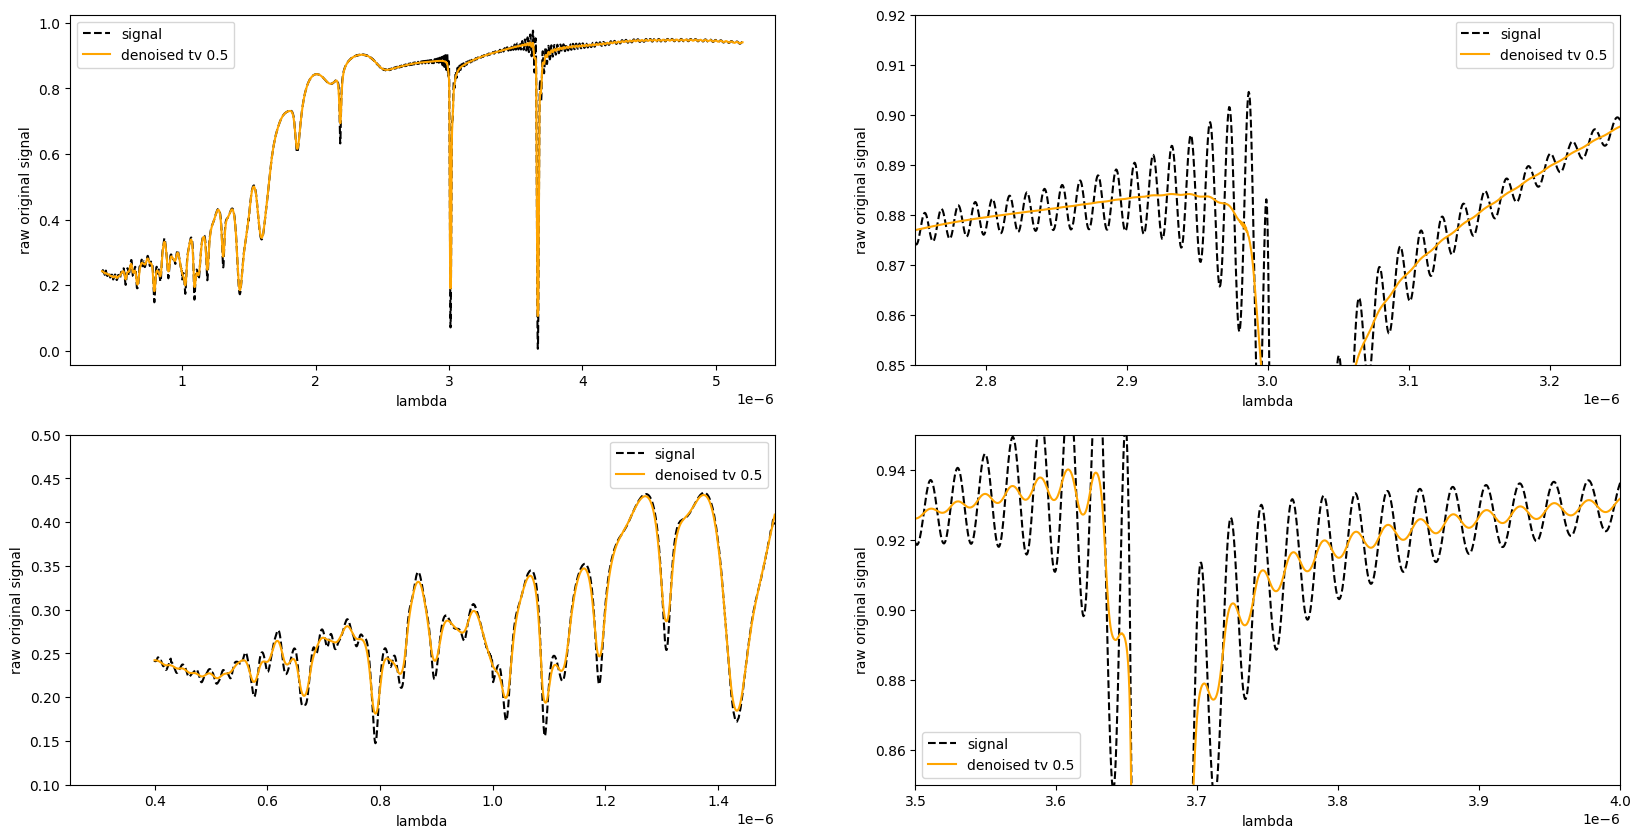

In [26]:
# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0],label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[0], color='orange',label='denoised tv 0.5')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[1],label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[1], color='orange',label='denoised tv 0.5')
ax[1].set_ylabel('raw original signal')
ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)

sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[2],label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[2], color='orange',label='denoised tv 0.5')
ax[2].set_ylabel('raw original signal')
ax[2].set_xlim(0.25e-6, 1.5e-6)
ax[2].set_ylim(0.1, 0.5)

sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[3],label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[3], color='orange',label='denoised tv 0.5')
ax[3].set_ylabel('raw original signal')
ax[3].set_xlim(3.5e-6, 4.0e-6)
ax[3].set_ylim(0.85, 0.95)

plt.show()

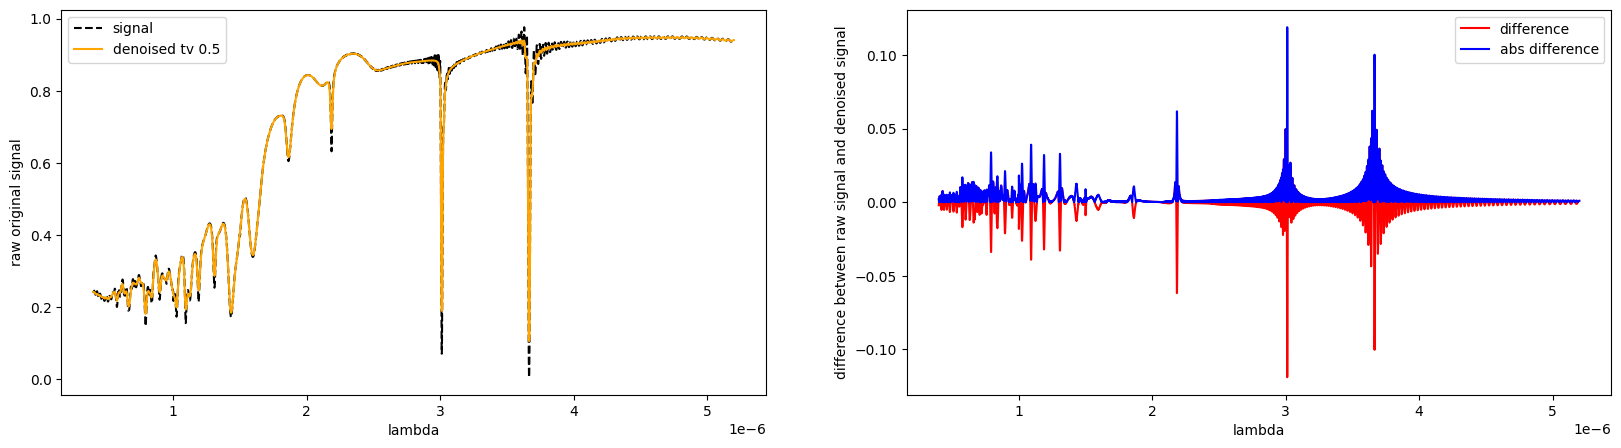

In [33]:
# now investigate the difference between the smoothed points and the original points for each wavelength
orig_test_df['diff'] = orig_test_df['signal'] - orig_test_df['smoothed_signal_tv_0.5']
orig_test_df['diff_abs'] = orig_test_df['diff'].abs()

fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0],label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[0], color='orange',label='denoised tv 0.5')
ax[0].set_ylabel('raw original signal')

sns.lineplot(x='lambda', y='diff', data=orig_test_df, ax=ax[1],label='difference',color='red')
sns.lineplot(x='lambda', y='diff_abs', data=orig_test_df, ax=ax[1],label='abs difference',color='blue')
ax[1].set_ylabel('difference between raw signal and denoised signal')
plt.show()

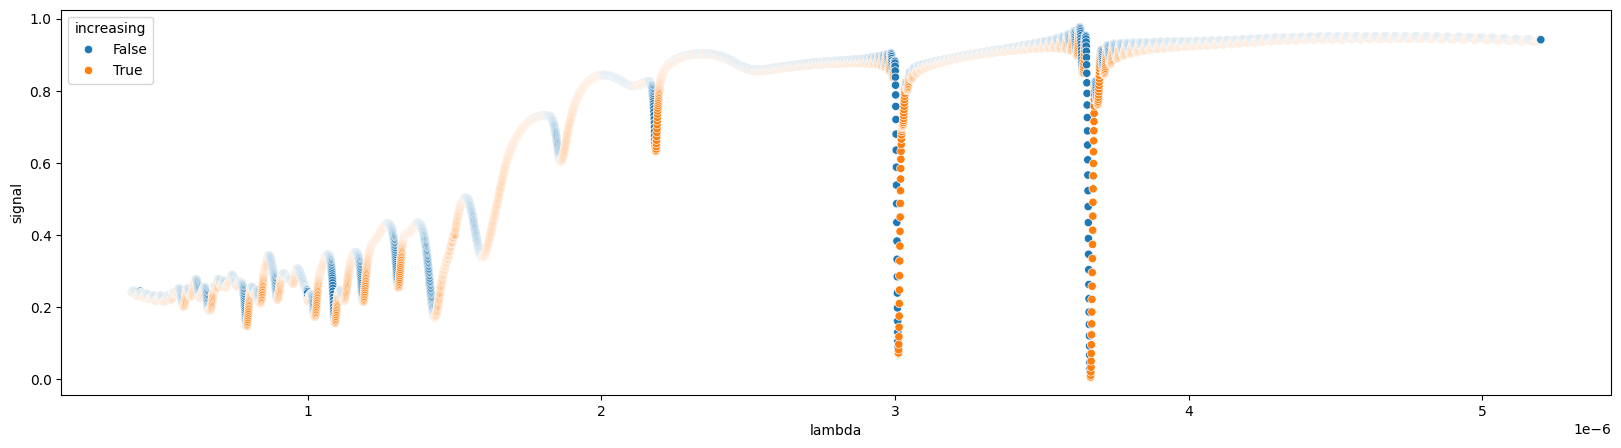

In [35]:
# now for each point determine if it is increasing or decreasing
orig_test_df['increasing'] = [s1 < s2 for s1,s2 in zip(orig_test_df['signal'][:-1], orig_test_df['signal'][1:])] + [False]

# plot a scatter plot of the increasing and decreasing points
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.scatterplot(x='lambda', y='signal', data=orig_test_df, hue='increasing', ax=ax)
plt.show()


In [ ]:
# now let's build a smaller dataset with only the inflection points (the points when the direction changes)
inflection_points_mask = [i1 != i2 for i1,i2, in zip(orig_test_df.increasing[:-1],orig_test_df.increasing[1:])] + [True]
orig_test_df["inflection_points"] = inflection_points_mask
inflection_points = pd.DataFrame(orig_test_df[inflection_points_mask])
inflection_points

lambda    signal  smoothed_signal_tv_0.5      diff  diff_abs  \
4      4.009600e-07  0.241614                0.242237 -0.000623  0.000623   
7      4.024000e-07  0.241393                0.242156 -0.000763  0.000763   
14     4.057610e-07  0.245458                0.241668  0.003790  0.003790   
43     4.196820e-07  0.231599                0.236528 -0.004929  0.004929   
61     4.283230e-07  0.243691                0.236571  0.007120  0.007120   
...             ...       ...                     ...       ...       ...   
9871   5.137590e-06  0.937701                0.938904 -0.001203  0.001203   
9912   5.157280e-06  0.943046                0.941878  0.001168  0.001168   
9958   5.179360e-06  0.936406                0.937567 -0.001161  0.001161   
9999   5.199040e-06  0.941694                0.940719  0.000975  0.000975   
10001  5.200000e-06  0.941702                0.940744  0.000958  0.000958   

       increasing  
4            True  
7           False  
14           True  
43          False  
61           True  
...           ...  
9871        False  
9912         True  
9958        False  
9999         True  
10001       False  

[478 rows x 6 columns]

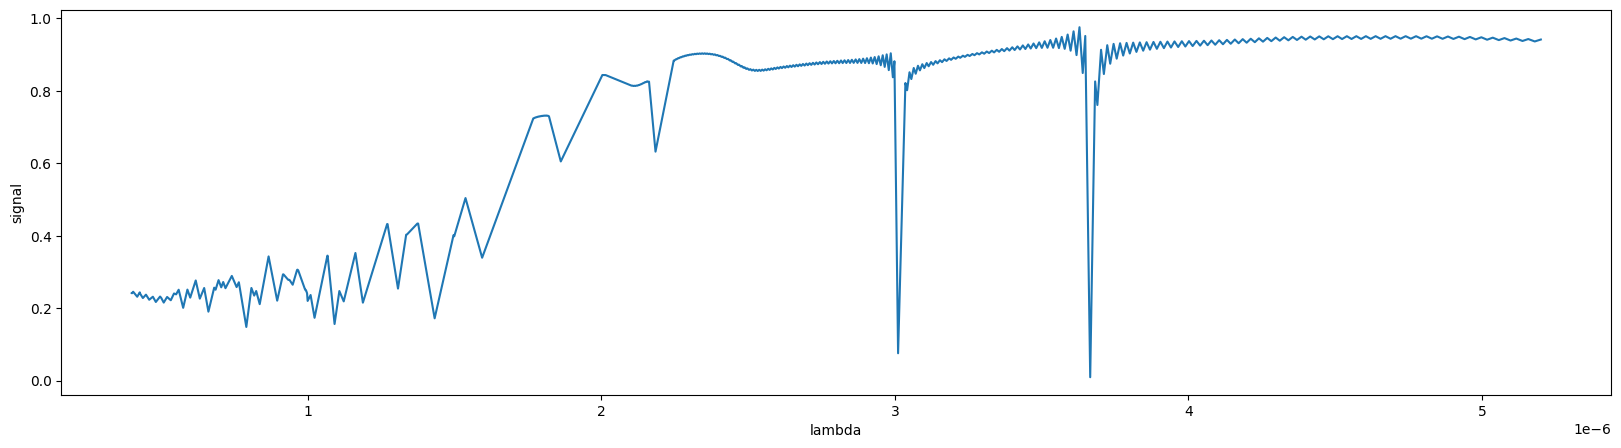

In [40]:
# plot a line plot of the inflection points
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=inflection_points, ax=ax)
plt.show()

In [51]:
# # try peak detection from audio signal processing

# import statsmodels.api as sm
# from scipy.signal import find_peaks

# auto = sm.tsa.acf(orig_test_df.signal, nlags=2000)

# fig,ax = plt.subplots(1,1,figsize=(20,5))
# sns.lineplot(x=range(len(auto)), y=auto, ax=ax)

In [52]:
# import numpy as np
# from skimage.restoration import denoise_tv_chambolle

# def sliding_window_tv_denoise(signal, window_size=100, overlap=50, weight=0.1):
#     step = window_size - overlap
#     denoised_signal = np.zeros_like(signal)
#     count = np.zeros_like(signal)
    
#     for i in range(0, len(signal) - window_size, step):
#         window = signal[i:i+window_size]
#         denoised_window = denoise_tv_chambolle(window, weight=weight)
        
#         denoised_signal[i:i+window_size] += denoised_window
#         count[i:i+window_size] += 1

#     # Avoid division by zero and normalize overlapping regions
#     count[count == 0] = 1
#     return denoised_signal / count

# # Apply sliding TV denoising
# orig_test_df["loc_sw_tv_ws1000_ov50_w0.5"] = sliding_window_tv_denoise(orig_test_df.signal, window_size=1000, overlap=50, weight=0.5)


In [53]:
# # create overlayed plots of the raw signal and the denoised signal
# fig, ax = plt.subplots(2,2, figsize=(20,10))
# ax = ax.ravel()
# alph = 0.7

# sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0],label='signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[0], color='orange',label='denoised tv 0.5')
# sns.lineplot(x='lambda', y=f'loc_sw_tv_ws1000_ov50_w0.5', data=orig_test_df, ax=ax[0], color='green',label='loc sw tv 0.5')
# ax[0].set_ylabel('raw original signal')

# sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[1],label='signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[1], color='orange',label='denoised tv 0.5')
# sns.lineplot(x='lambda', y=f'loc_sw_tv_ws1000_ov50_w0.5', data=orig_test_df, ax=ax[1], color='green',label='loc sw tv 0.5')
# ax[1].set_ylabel('raw original signal')
# ax[1].set_xlim(2.75e-6, 3.25e-6)
# ax[1].set_ylim(0.85, 0.92)

# sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[2],label='signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[2], color='orange',label='denoised tv 0.5')
# sns.lineplot(x='lambda', y=f'loc_sw_tv_ws1000_ov50_w0.5', data=orig_test_df, ax=ax[2], color='green',label='loc sw tv 0.5')
# ax[2].set_ylabel('raw original signal')
# ax[2].set_xlim(0.25e-6, 1.5e-6)
# ax[2].set_ylim(0.1, 0.5)

# sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[3],label='signal',color='black',linestyle='dashed')
# sns.lineplot(x='lambda', y=f'smoothed_signal_tv_0.5', data=orig_test_df, ax=ax[3], color='orange',label='denoised tv 0.5')
# sns.lineplot(x='lambda', y=f'loc_sw_tv_ws1000_ov50_w0.5', data=orig_test_df, ax=ax[3], color='green',label='loc sw tv 0.5')
# ax[3].set_ylabel('raw original signal')
# ax[3].set_xlim(3.5e-6, 4.0e-6)
# ax[3].set_ylim(0.85, 0.95)

# plt.show()

In [90]:
# let's try a different approach where we assume that any noise point follows some periodicity
# for each point we can check if it is increasing or decreasing and find the distance to the 
# next point that is in the opposite direction (check both sides) that has the minimum 
# absolute difference in signal

# assign each direction block a unique number
direction_nums = []
direction_num = 0
for d1,d2 in zip(orig_test_df.increasing[:-1], orig_test_df.increasing[1:]):
    if d1 != d2:
        direction_num += 1
    direction_nums.append(direction_num)
direction_nums.append(direction_num)
orig_test_df["direction_num"] = direction_nums

original_signals = np.array(orig_test_df.signal)

localized_period = []
period_diff = []
for i,s,dn in zip(tqdm(orig_test_df.index),original_signals, orig_test_df.direction_num):
    dnums_to_include = set()
    if dn > 1:
        dnums_to_include.add(dn-2)
    if dn < direction_num-1:
        dnums_to_include.add(dn+2)
    df_subs = orig_test_df[orig_test_df.direction_num.isin(dnums_to_include)]
    min_diff = np.inf
    min_index = -1
    for j,s2 in zip(df_subs.index, df_subs.signal):
        if abs(s-s2) < min_diff:
            min_diff = abs(s-s2)
            min_index = j
    localized_period.append(min_index-i)
    period_diff.append(min_diff)
orig_test_df["localized_period"] = localized_period
orig_test_df["period_diff"] = period_diff

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:03<00:00, 2805.20it/s]


In [76]:
original_signals[7374-10:7374], original_signals[7374], original_signals[7374+1:7374+11]  

(array([0.927209, 0.926178, 0.925174, 0.924213, 0.923311, 0.922481,
        0.921737, 0.921089, 0.920548, 0.920123]),
 np.float64(0.919819),
 array([0.919642, 0.919594, 0.919675, 0.919885, 0.920219, 0.920673,
        0.92124 , 0.92191 , 0.922673, 0.923518]))

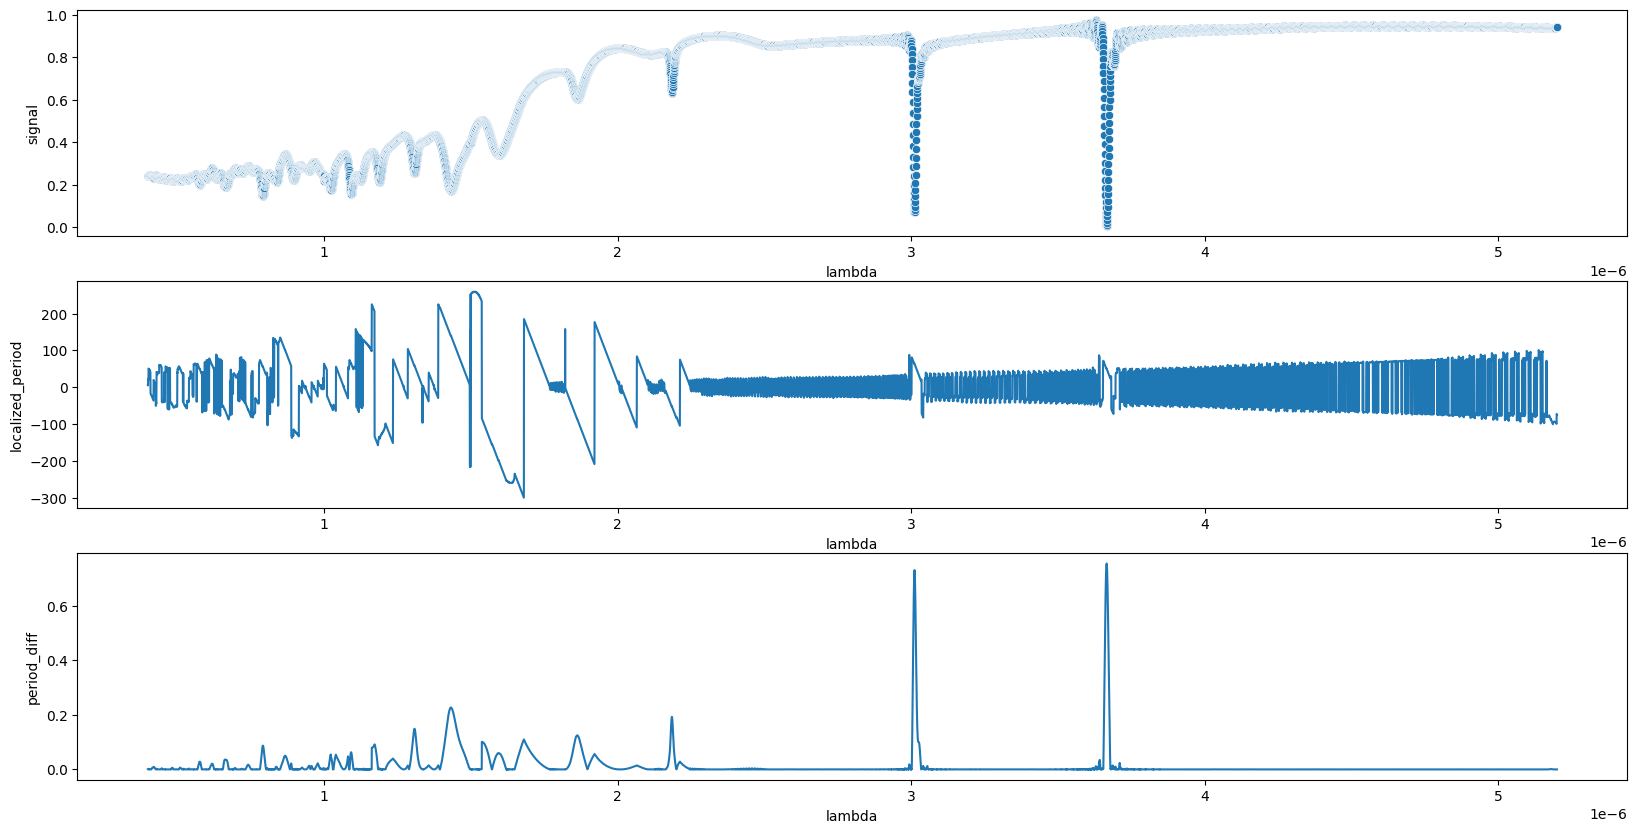

In [91]:
# plot the original signal on top and the localized period on the bottom
fig,ax = plt.subplots(3,1,figsize=(20,10))
sns.scatterplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0])
sns.lineplot(x='lambda', y='localized_period', data=orig_test_df, ax=ax[1])
sns.lineplot(x='lambda', y='period_diff', data=orig_test_df, ax=ax[2])
plt.show()

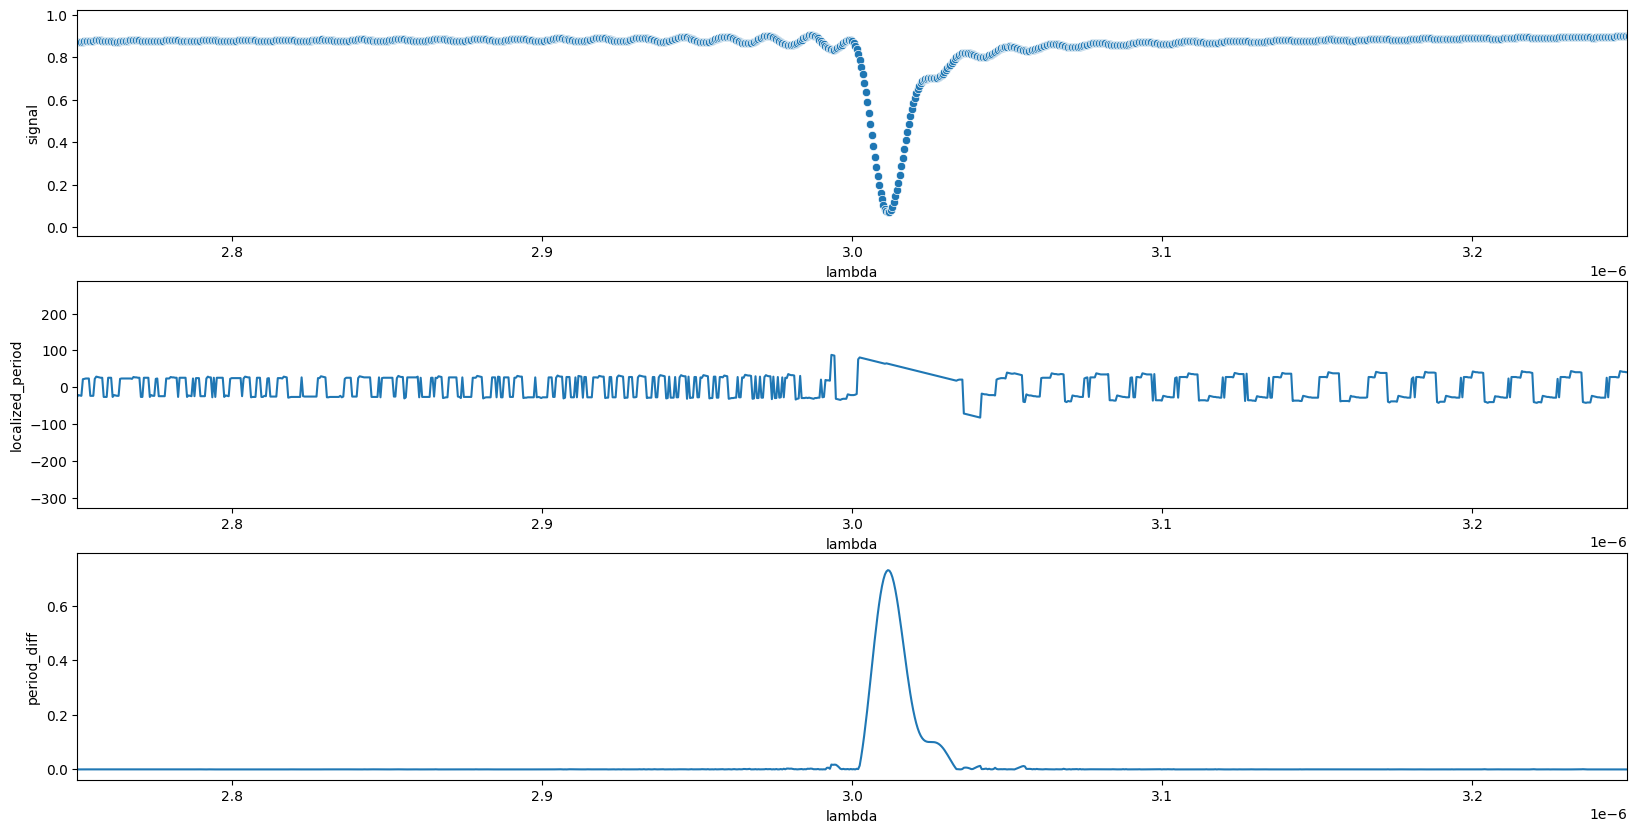

In [92]:
# zoom in
# plot the original signal on top and the localized period on the bottom
fig,ax = plt.subplots(3,1,figsize=(20,10))
sns.scatterplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0])
ax[0].set_xlim(2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='localized_period', data=orig_test_df, ax=ax[1])
ax[1].set_xlim(2.75e-6, 3.25e-6)
sns.lineplot(x='lambda', y='period_diff', data=orig_test_df, ax=ax[2])
ax[2].set_xlim(2.75e-6, 3.25e-6)
plt.show()

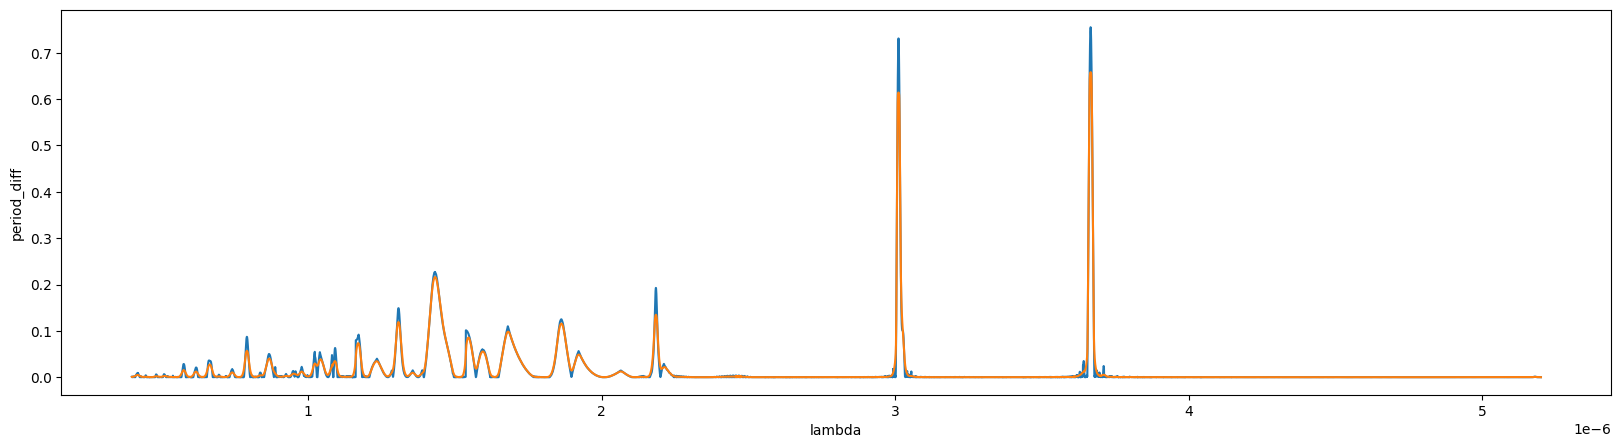

In [128]:
# ok now what if we denoise the diff signal and extract the local optima from that
diff = orig_test_df["period_diff"]
diff_denoised = np.array(denoise_tv_chambolle(diff, weight=0.5))

# now plot the diff signal and the denoised diff signal
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.lineplot(x=orig_test_df["lambda"], y=diff, ax=ax)
sns.lineplot(x=orig_test_df["lambda"], y=diff_denoised, ax=ax)
plt.show()

In [168]:
# lets say that the global minimum is at the location of the max of diff
global_min = orig_test_df.loc[orig_test_df["period_diff"].idxmax()]
global_min

lambda                        0.000004
signal                        0.005539
smoothed_signal_tv_0.5        0.105815
diff                         -0.100276
diff_abs                      0.100276
increasing                        True
loc_sw_tv_ws100_ov50_w0.5     0.066462
loc_sw_tv_ws1000_ov50_w0.5    0.099071
localized_period                    51
direction_num                      374
period_diff                   0.755061
diff_thresholded                  True
keep_dir                          True
Name: 6805, dtype: object

In [173]:
# specifically I want to find the the largest local minima next to the global minima
# so only restricting the search to a 1000 points on either side of the global minima
win_size = 100
global_min_index = diff.idxmax()
local_minima = []

extracted_window = orig_test_df.iloc[global_min_index-win_size:global_min_index+win_size]
for d,dp,dn in zip(extracted_window["period_diff"][1:-1],extracted_window["period_diff"][:-2],extracted_window["period_diff"][2:]):
    if d > dp and d > dn and d != global_min["period_diff"]:
        local_minima.append(d)
print(len(local_minima), max(local_minima))
thresh = round(max(local_minima)+0.0005,3)
print(thresh)

38 0.0349560000000001
0.035


In [174]:
# now all local maxima of the period_diff that are above the threshold are considered real local minima
local_minima = []

for ind,d,i in zip(orig_test_df.index, orig_test_df["period_diff"], range(len(orig_test_df))):
    if d > thresh and i > 0 and i < len(orig_test_df)-1 and orig_test_df["period_diff"].values[i-1] < d and orig_test_df["period_diff"].values[i+1] < d:
        local_minima.append(ind)
print(len(local_minima))

24


In [175]:
# # find the lambda values where the denoised diff signal is at a local maximum
# # a local maximum is defined as a point where the signal is greater than all 
# # the surrounding win_size points and is > than mult x the smallest win_size points
# local_maxima = []
# win_size = 100
# mult_factor = 3.00
# for i in range(win_size,len(diff_denoised)-win_size):
#     smallest = min(diff_denoised[i-win_size:i+win_size])
#     if diff_denoised[i] > mult_factor*smallest and all([diff_denoised[i] >= d for d in diff_denoised[i-win_size:i+win_size]]):
#         local_maxima.append(i)
# print(len(local_maxima))

In [ ]:
# for each of the local maxima we want to preserve the set of points that are in the same direction as the local maximum and the set of points that are in the next direction

keep_dirs = set()
for lm in local_minima:
    keep_dirs.add(orig_test_df.direction_num.values[lm])
    if orig_test_df.direction_num.values[lm] > 0:
        keep_dirs.add(orig_test_df.direction_num.values[lm]-1)

orig_test_df["keep_dir"] = [dn in keep_dirs for dn in orig_test_df.direction_num]

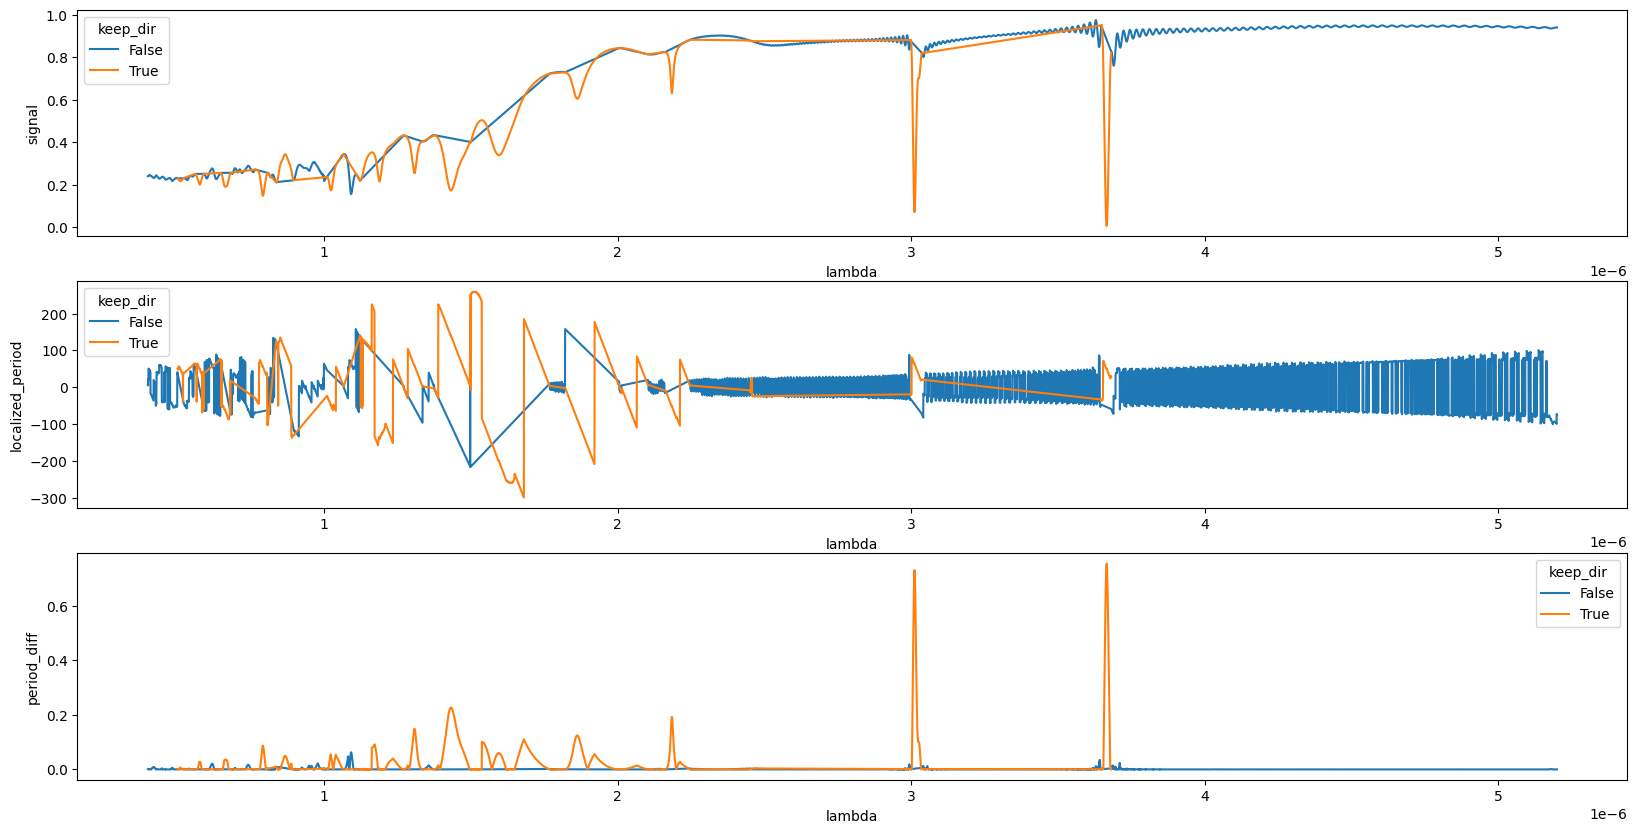

In [177]:
# plot the original signal on top and the localized period on the bottom
fig,ax = plt.subplots(3,1,figsize=(20,10))
sns.lineplot(x='lambda', y='signal', data=orig_test_df, ax=ax[0], hue='keep_dir')
sns.lineplot(x='lambda', y='localized_period', data=orig_test_df, ax=ax[1],hue='keep_dir')
sns.lineplot(x='lambda', y='period_diff', data=orig_test_df, ax=ax[2], hue='keep_dir')
plt.show()

In [258]:
# now we split into 2 datasets, one with the keep_dir and one without
orig_test_df_keep = pd.DataFrame(orig_test_df[orig_test_df.keep_dir])
orig_test_df_no_keep = pd.DataFrame(orig_test_df[~orig_test_df.keep_dir])

# now we smooth the signal for the no keep dataset with the total variation denoising
# weight = 0.5 & 1_000 iterations
weight = 0.5
niter = 10
cur_buffer = []
denoised_data = []
for s,k in zip(orig_test_df.signal, orig_test_df.keep_dir):
    if k:
        if len(cur_buffer) > 0:
            cur_buffer = np.array(cur_buffer)
            # for _ in range(niter):
            #     cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
            # try a rolling window approach instead
            cur_buffer = pd.Series(cur_buffer).rolling(window=100, min_periods=1).median().values
            for _ in range(niter):
                cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
            denoised_data.extend(cur_buffer)
            cur_buffer = []
    else:
        cur_buffer.append(s)
if len(cur_buffer) > 0:
    cur_buffer = np.array(cur_buffer)
    for _ in range(niter):
        cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
    denoised_data.extend(cur_buffer)
# len(orig_test_df_no_keep), len(denoised_data)
orig_test_df_no_keep[f"smoothed_signal_tv_{weight}_{niter}"] = denoised_data



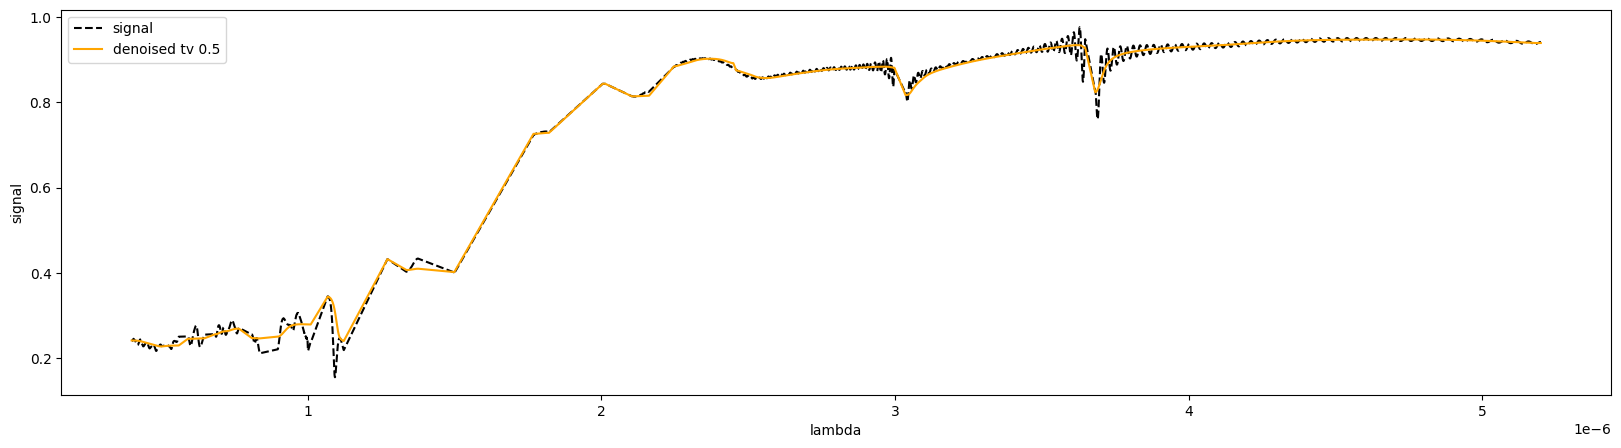

In [259]:
# first we want to see the data after denoising
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=orig_test_df_no_keep, ax=ax,label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y=f'smoothed_signal_tv_{weight}_{niter}', data=orig_test_df_no_keep, ax=ax, color='orange',label='denoised tv 0.5')
plt.show()

In [269]:
# now we want to stitch the two datasets back together
final_df_list = []

# first we need to store the lambda, signal, and smoothed signal for the keep dataset into a deque sorted by lambda
keep_deque = deque(sorted(zip(orig_test_df_keep["lambda"], orig_test_df_keep["signal"], orig_test_df_keep["increasing"])))
# then we need to store the lambda, signal, and smoothed signal for the no keep dataset into a deque sorted by lambda
no_keep_deque = deque(sorted(zip(orig_test_df_no_keep["lambda"], orig_test_df_no_keep["signal"], orig_test_df_no_keep[f'smoothed_signal_tv_{weight}_{niter}'], orig_test_df_no_keep["increasing"])))

# now we iterate through the no keep dataset
while len(no_keep_deque) > 0:
    # first check if the keep dataset is empty
    if len(keep_deque) > 0 and no_keep_deque[0][0] > keep_deque[0][0]:
        # now we check if the no keep dataset lambda is less than the keep dataset lambda
        pl,ps,pdi,pk,psd = final_df_list[-1]
        nl,ns,nd = keep_deque.popleft()
        # note if we notice that the difference between the smoothed signal and the signal is 
        # greater than 0.01 and the previous point was from the no keep dataset then we want to replace the value with the previous value
        if abs(ns-psd) > 0.01 and not pk:
            nsd = psd
        else:
            if nd:
                nsd = max(ns,psd)
            else:
                nsd = min(ns,psd)
        final_df_list.append((nl,ns,nd,True,nsd))
    else:
        nl,ns,nsd,nd = no_keep_deque.popleft()
        final_df_list.append((nl,ns,nd,False,nsd))
print(len(final_df_list), len(orig_test_df))
    

10000 10000


In [270]:
local_smoothing_patched = pd.DataFrame(final_df_list, columns=["lambda","signal","increasing","local optima","smoothed_signal"])

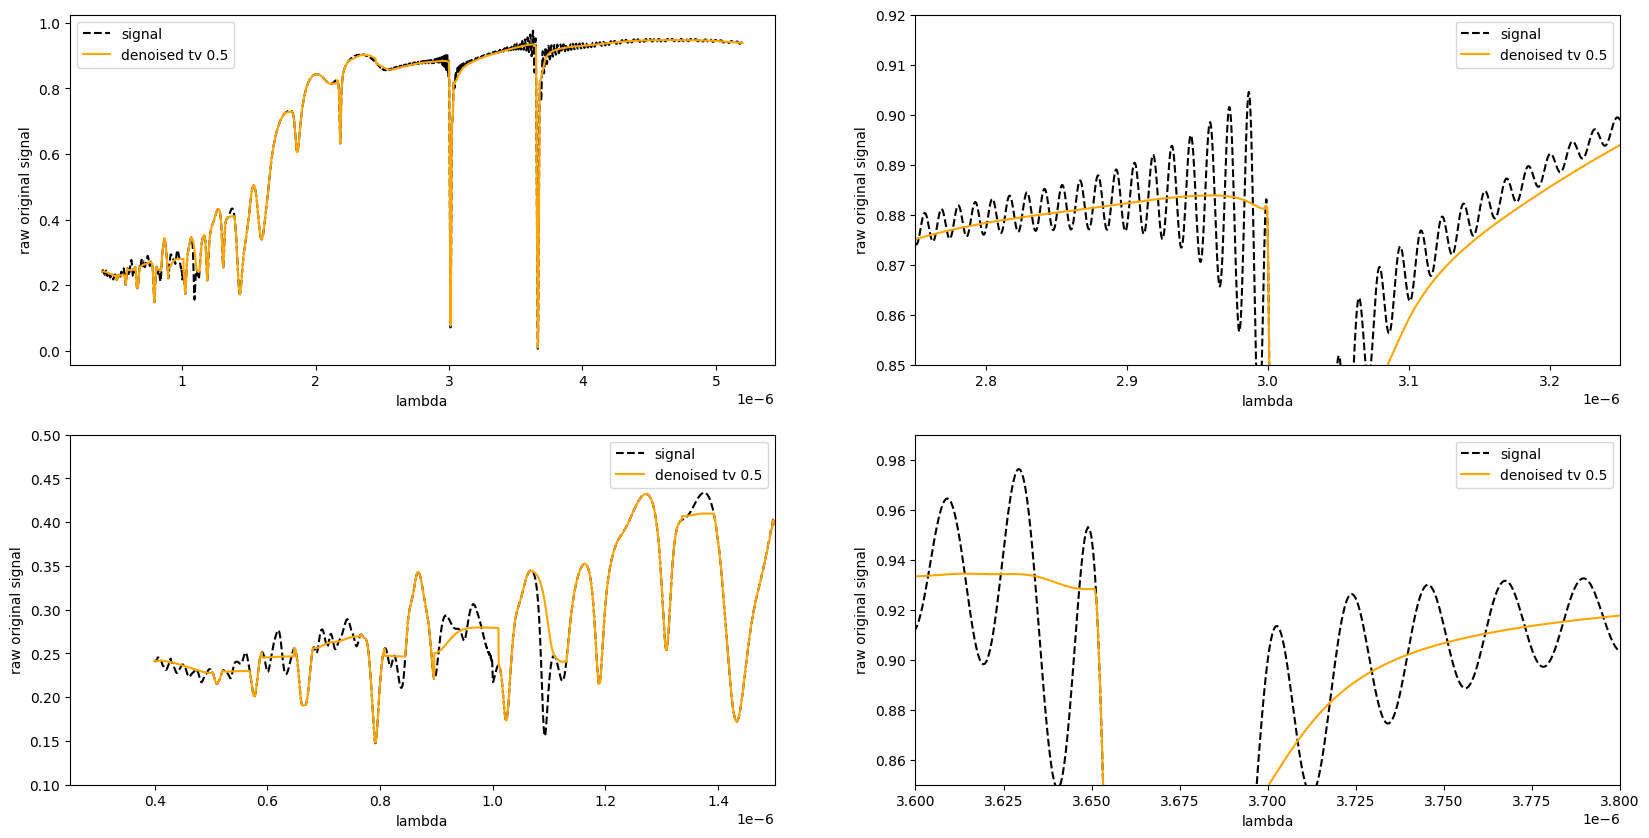

In [272]:
# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

for i in range(4):
    sns.lineplot(x='lambda', y='signal', data=local_smoothing_patched, ax=ax[i],label='signal',color='black',linestyle='dashed')
    sns.lineplot(x='lambda', y='smoothed_signal', data=local_smoothing_patched, ax=ax[i], color='orange',label='denoised tv 0.5')
    #sns.scatterplot(x='lambda', y='smoothed_signal', data=local_smoothing_patched, ax=ax[i], hue='increasing', palette='viridis')
    ax[i].set_ylabel('raw original signal')

ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)

ax[2].set_xlim(0.25e-6, 1.5e-6)
ax[2].set_ylim(0.1, 0.5)

ax[3].set_xlim(3.6e-6, 3.8e-6)
ax[3].set_ylim(0.85, 0.99)

plt.show()

<Axes: xlabel='lambda', ylabel='signal'>

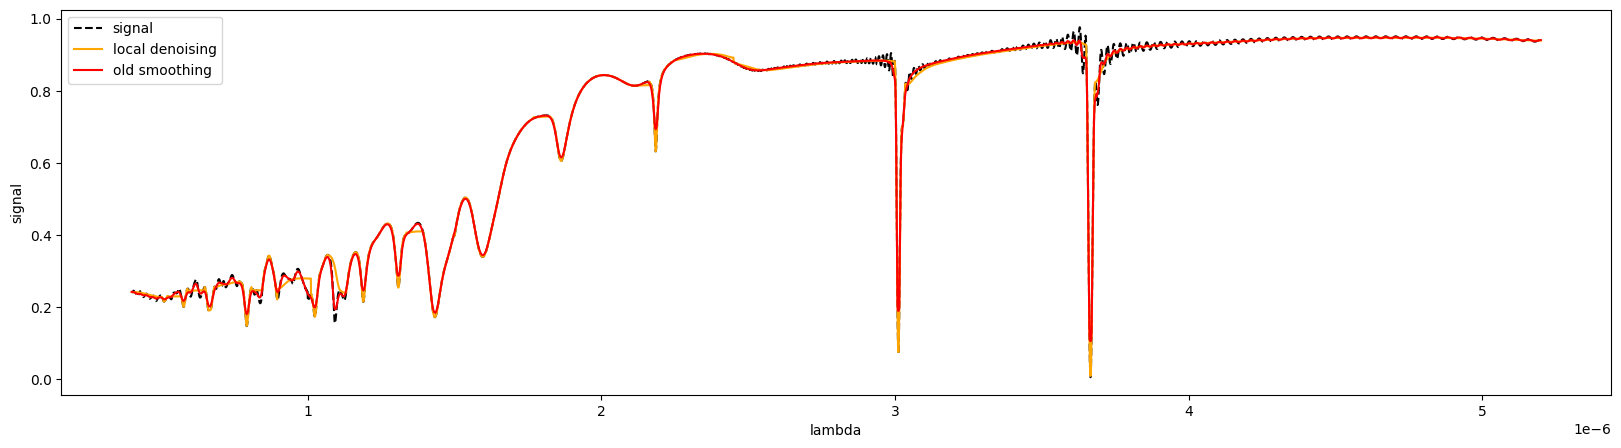

In [275]:
# plot only the local optima = True points
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.lineplot(x='lambda', y='signal', data=local_smoothing_patched, ax=ax,label='signal',color='black',linestyle='dashed')
sns.lineplot(x='lambda', y='smoothed_signal', data=local_smoothing_patched, ax=ax, color='orange',label='local denoising')
sns.lineplot(x='lambda', y='smoothed_signal_tv_0.5', data=df_no_na, ax=ax, color='red',label='old smoothing')

In [322]:
print(thresh)

0.035


hmmm not sure how effective this approach actually is ...

from what I have learned about the data, it seems that a 2-pronged approach is better
- the low lambda values either are not noisy or noise is indiscernable from signal
- the high lambda values have strong signal and easily distinguishable noise
- for values with lambda \< 2e-6, i can apply a basic total variation smoothing approach
- for values with higher lambda, i can employ the optima preserving approach discussed above

In [376]:
def custom_denoise(noisy_data):
    # first create a copy of noisy data
    denoised_data = noisy_data.copy(deep=True)
    # first split the data into 2 parts lambda < 2e-6 and lambda >= 2e-6
    lambda_thresh = 2e-6
    p1 = pd.DataFrame(noisy_data[noisy_data["lambda"] < lambda_thresh])
    p2 = pd.DataFrame(noisy_data[noisy_data["lambda"] >= lambda_thresh])

    # now we want to denoise the first part using the total variation denoising with weight 0.5
    weight = 0.5
    niter = 1
    p1_denoised = np.array(p1["signal"])
    for _ in range(niter):
        p1_denoised = denoise_tv_chambolle(p1_denoised, weight=weight)
    p1["smoothed_signal"] = p1_denoised

    # now we want to denoise the second part using the local preserver denoising
    # that we established in the earlier cells
    p2['increasing'] = [s1 < s2 for s1, s2 in zip(p2['signal'][:-1], p2['signal'][1:])] + [False]
    p2['diff'] = p2['signal'] - p2['signal'].shift(1)
    p2['diff_abs'] = p2['diff'].abs()

    direction_nums = []
    direction_num = 0
    for d1, d2 in zip(p2.increasing[:-1], p2.increasing[1:]):
        if d1 != d2:
            direction_num += 1
        direction_nums.append(direction_num)
    direction_nums.append(direction_num)
    p2["direction_num"] = direction_nums

    original_signals = np.array(p2.signal)

    localized_period = []
    period_diff = []
    for i, s, dn in zip(tqdm(p2.index), original_signals, p2.direction_num):
        dnums_to_include = set()
        if dn > 1:
            dnums_to_include.add(dn - 2)
        if dn < direction_num - 1:
            dnums_to_include.add(dn + 2)
        df_subs = p2[p2.direction_num.isin(dnums_to_include)]
        min_diff = np.inf
        min_index = -1
        for j, s2 in zip(df_subs.index, df_subs.signal):
            if abs(s - s2) < min_diff:
                min_diff = abs(s - s2)
                min_index = j
        localized_period.append(min_index - i)
        period_diff.append(min_diff)
    p2["localized_period"] = localized_period
    p2["period_diff"] = period_diff

    diff = p2["period_diff"]
    diff_denoised = np.array(denoise_tv_chambolle(diff, weight=0.5))
    # lets say that the global minimum is at the location of the max of diff
    global_min = p2.loc[p2["period_diff"].idxmax()]
    win_size = 100
    global_min_index = diff.idxmax()
    local_minima = []
    #print(global_min)
    extracted_window = p2.loc[global_min_index - win_size:global_min_index + win_size]
    #print(extracted_window.shape)
    for d, dp, dn in zip(extracted_window["period_diff"][1:-1], extracted_window["period_diff"][:-2], extracted_window["period_diff"][2:]):
        if d > dp and d > dn and d != global_min["period_diff"]:
            local_minima.append(d)
    #thresh = round(max(local_minima) + 0.001, 3)
    thresh = 0.1
    
    local_minima = []

    for ind,d,i in zip(p2.index, p2["period_diff"], range(len(p2))):
        if d > thresh and i > 0 and i < len(p2)-1 and p2["period_diff"].values[i-1] < d and p2["period_diff"].values[i+1] < d:
            local_minima.append(ind)
    print(len(local_minima))

    keep_dirs = set()
    for lm in local_minima:
        keep_dirs.add(p2.loc[lm].direction_num)
        if p2.loc[lm].direction_num > 0:
            keep_dirs.add(p2.loc[lm].direction_num - 1)

    p2["keep_dir"] = [dn in keep_dirs for dn in p2.direction_num]
    print(keep_dirs)
    if len(keep_dirs) == 0:
        # in this case we just apply the p1 denoising to the whole dataset and forget about preserving the local optima
        denoised_data["smoothed_signal"] = np.array(denoised_data["signal"])
        weight = 0.5
        niter = 5
        for _ in range(niter):
            denoised_data["smoothed_signal"] = denoise_tv_chambolle(denoised_data["smoothed_signal"], weight=weight)
        return denoised_data

    # now we split into 2 datasets, one with the keep_dir and one without
    p2_keep = pd.DataFrame(p2[p2.keep_dir])
    p2_no_keep = pd.DataFrame(p2[~p2.keep_dir])

    # now we smooth the signal for the no keep dataset with the total variation denoising
    # weight = 0.5 & 1_000 iterations
    weight = 0.5
    niter = 1000
    cur_buffer = []
    denoised_data = []
    for s,k in zip(p2.signal, p2.keep_dir):
        if k:
            if len(cur_buffer) > 0:
                cur_buffer = np.array(cur_buffer)
                # for _ in range(niter):
                #     cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
                # try a rolling window approach instead
                cur_buffer = pd.Series(cur_buffer).rolling(window=100, min_periods=1).median().values
                for _ in range(niter):
                    cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
                denoised_data.extend(cur_buffer)
                cur_buffer = []
        else:
            cur_buffer.append(s)
    if len(cur_buffer) > 0:
        cur_buffer = np.array(cur_buffer)
        for _ in range(niter):
            cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
        denoised_data.extend(cur_buffer)
    # len(orig_test_df_no_keep), len(denoised_data)
    p2_no_keep[f"smoothed_signal_tv_{weight}_{niter}"] = denoised_data

    # now we want to stitch the two datasets back together
    final_df_list = []

    # first we need to store the lambda, signal, and smoothed signal for the keep dataset into a deque sorted by lambda
    keep_deque = deque(sorted(zip(p2_keep["lambda"], p2_keep["signal"], p2_keep["increasing"])))
    # then we need to store the lambda, signal, and smoothed signal for the no keep dataset into a deque sorted by lambda
    no_keep_deque = deque(sorted(zip(p2_no_keep["lambda"], p2_no_keep["signal"], p2_no_keep[f'smoothed_signal_tv_{weight}_{niter}'], p2_no_keep["increasing"])))
    print(len(keep_deque), len(no_keep_deque))
    # now we iterate through the no keep dataset
    while len(no_keep_deque) > 0:
        # first check if the keep dataset is empty
        if len(keep_deque) > 0 and no_keep_deque[0][0] > keep_deque[0][0]:
            nl,ns,nd = keep_deque.popleft()
            nsd = nd
            if len(final_df_list) > 0:
                # now we check if the no keep dataset lambda is less than the keep dataset lambda
                pl,ps,pdi,pk,psd = final_df_list[-1]
                
                # note if we notice that the difference between the smoothed signal and the signal is 
                # greater than 0.01 and the previous point was from the no keep dataset then we want to replace the value with the previous value
                if abs(ns-psd) > 0.01:
                    if not pk:
                        if ns > psd:
                            nsd = psd + 0.01
                        else:
                            nsd = psd - 0.01
                    else:
                        # replace with the average of the two
                        nsd = (ns + psd) / 2
                else:
                    if nd:
                        nsd = max(ns,psd)
                    else:
                        nsd = min(ns,psd)
            final_df_list.append((nl,ns,nd,True,nsd))
        else:
            nl,ns,nsd,nd = no_keep_deque.popleft()
            # now we need to make sure smooth transition from the keep dataset to the no keep dataset
            if len(final_df_list) > 0:
                pl,ps,pdi,pk,psd = final_df_list[-1]
                if abs(nsd-psd) > 0.01:
                    if pk:
                        if nsd > psd:
                            nsd = psd + 0.01
                        else:
                            nsd = psd - 0.01
                    else:
                        # replace with the average of the two
                        nsd = (nsd + psd) / 2
            final_df_list.append((nl,ns,nd,False,nsd))
    #print(len(final_df_list), len(p2))

    local_smoothing_patched = pd.DataFrame(final_df_list, columns=["lambda","signal","increasing","local optima","smoothed_signal"])
    #print(noisy_data.shape,p1.shape,p2.shape,local_smoothing_patched.shape)
    result = pd.concat([p1[["lambda","signal","smoothed_signal"]], local_smoothing_patched], axis=0).reset_index(drop=True)

    # now we need to make sure there is no stitching artifact at the lambda_thresh
    # so we will just force a linear progression to the 50 points around the lambda_thresh
    # first get the index closest to the lambda_thresh
    lambda_thresh_index = result["lambda"].sub(lambda_thresh).abs().idxmin()
    # now split into 3 parts, before, at, and after the lambda_thresh
    p1 = pd.DataFrame(result.loc[:lambda_thresh_index-25])
    p2 = pd.DataFrame(result.loc[lambda_thresh_index-25:lambda_thresh_index+25])
    p3 = pd.DataFrame(result.loc[lambda_thresh_index+25:])
    # now force the linear progression
    p2["smoothed_signal"] = np.linspace(p1["smoothed_signal"].values[-1], p3["smoothed_signal"].values[0], 51)
    # now stitch the 3 parts back together
    result = pd.concat([p1,p2,p3], axis=0).drop_duplicates(subset=["lambda"]).reset_index(drop=True)
    return result

custom_denoised = custom_denoise(df_no_na)
custom_denoised

100%|██████████| 6667/6667 [00:06<00:00, 994.17it/s] 


3
{np.int64(169), np.int64(170), np.int64(243), np.int64(244), np.int64(23), np.int64(24)}
323 6344


lambda    signal  smoothed_signal increasing local optima
0     4.000000e-07  0.240174         0.242244        NaN          NaN
1     4.004800e-07  0.241098         0.242237        NaN          NaN
2     4.009600e-07  0.241614         0.242224        NaN          NaN
3     4.014400e-07  0.241734         0.242203        NaN          NaN
4     4.019200e-07  0.241592         0.242176        NaN          NaN
...            ...       ...              ...        ...          ...
9995  5.198080e-06  0.941626         0.939321       True        False
9996  5.198560e-06  0.941668         0.939320       True        False
9997  5.199040e-06  0.941694         0.939319       True        False
9998  5.199520e-06  0.941706         0.939319      False        False
9999  5.200000e-06  0.941702         0.939319      False        False

[10000 rows x 5 columns]

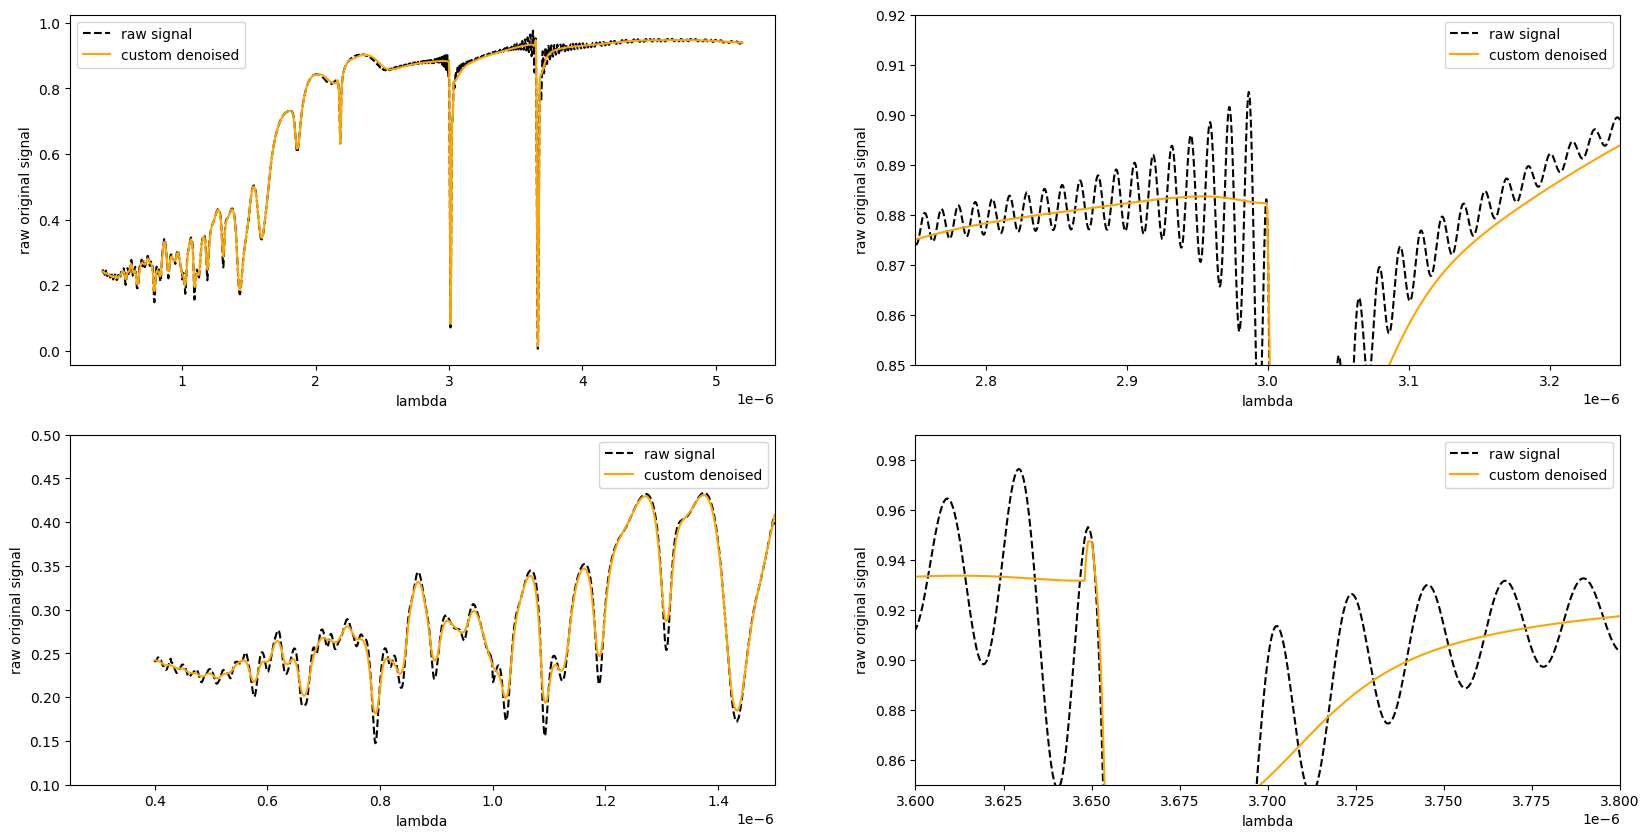

In [377]:
# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

for i in range(4):
    sns.lineplot(x='lambda', y='signal', data=custom_denoised, ax=ax[i],label='raw signal',color='black',linestyle='dashed')
    sns.lineplot(x='lambda', y='smoothed_signal', data=custom_denoised, ax=ax[i], color='orange',label='custom denoised')
    #sns.scatterplot(x='lambda', y='smoothed_signal', data=local_smoothing_patched[local_smoothing_patched["local optima"] == True], ax=ax[i], hue='local optima', palette='viridis', style='increasing')
    ax[i].set_ylabel('raw original signal')

ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)

ax[2].set_xlim(0.25e-6, 1.5e-6)
ax[2].set_ylim(0.1, 0.5)

ax[3].set_xlim(3.6e-6, 3.8e-6)
ax[3].set_ylim(0.85, 0.99)

plt.show()

In [378]:
# try the data on the TE 1.45 data
test_data = pd.DataFrame(new_data[f'p2000-base1200-h2000_TM_1.3'])
test_data

lambda    signal  smoothed_signal_tv_0.5_1000  \
0     4.000000e-07  0.106786                     0.116661   
1     4.004800e-07  0.106923                     0.116662   
2     4.009600e-07  0.107420                     0.116664   
3     4.014400e-07  0.108142                     0.116668   
4     4.019200e-07  0.109033                     0.116672   
...            ...       ...                          ...   
9995  5.198080e-06  0.851291                     0.850476   
9996  5.198560e-06  0.851355                     0.850475   
9997  5.199040e-06  0.851418                     0.850474   
9998  5.199520e-06  0.851482                     0.850474   
9999  5.200000e-06  0.851547                     0.850474   

     optima_preserving_denoising  
0                       0.113362  
1                       0.113388  
2                       0.113442  
3                       0.113522  
4                       0.113629  
...                          ...  
9995                    0.850991  
9996                    0.850988  
9997                    0.850987  
9998                    0.850985  
9999                    0.850985  

[10000 rows x 4 columns]

In [379]:
custom_denoised2 = custom_denoise(test_data)
custom_denoised2

  0%|          | 0/6667 [00:00<?, ?it/s]

100%|██████████| 6667/6667 [00:06<00:00, 985.93it/s] 


5
{np.int64(0), np.int64(1), np.int64(52), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(53)}
3107 3560


lambda    signal smoothed_signal increasing local optima
0     4.000000e-07  0.106786        0.113362        NaN          NaN
1     4.004800e-07  0.106923        0.113388        NaN          NaN
2     4.009600e-07  0.107420        0.113442        NaN          NaN
3     4.014400e-07  0.108142        0.113522        NaN          NaN
4     4.019200e-07  0.109033        0.113629        NaN          NaN
...            ...       ...             ...        ...          ...
9995  5.198080e-06  0.851291        0.850991       True        False
9996  5.198560e-06  0.851355        0.850988       True        False
9997  5.199040e-06  0.851418        0.850987       True        False
9998  5.199520e-06  0.851482        0.850985       True        False
9999  5.200000e-06  0.851547        0.850985      False        False

[10000 rows x 5 columns]

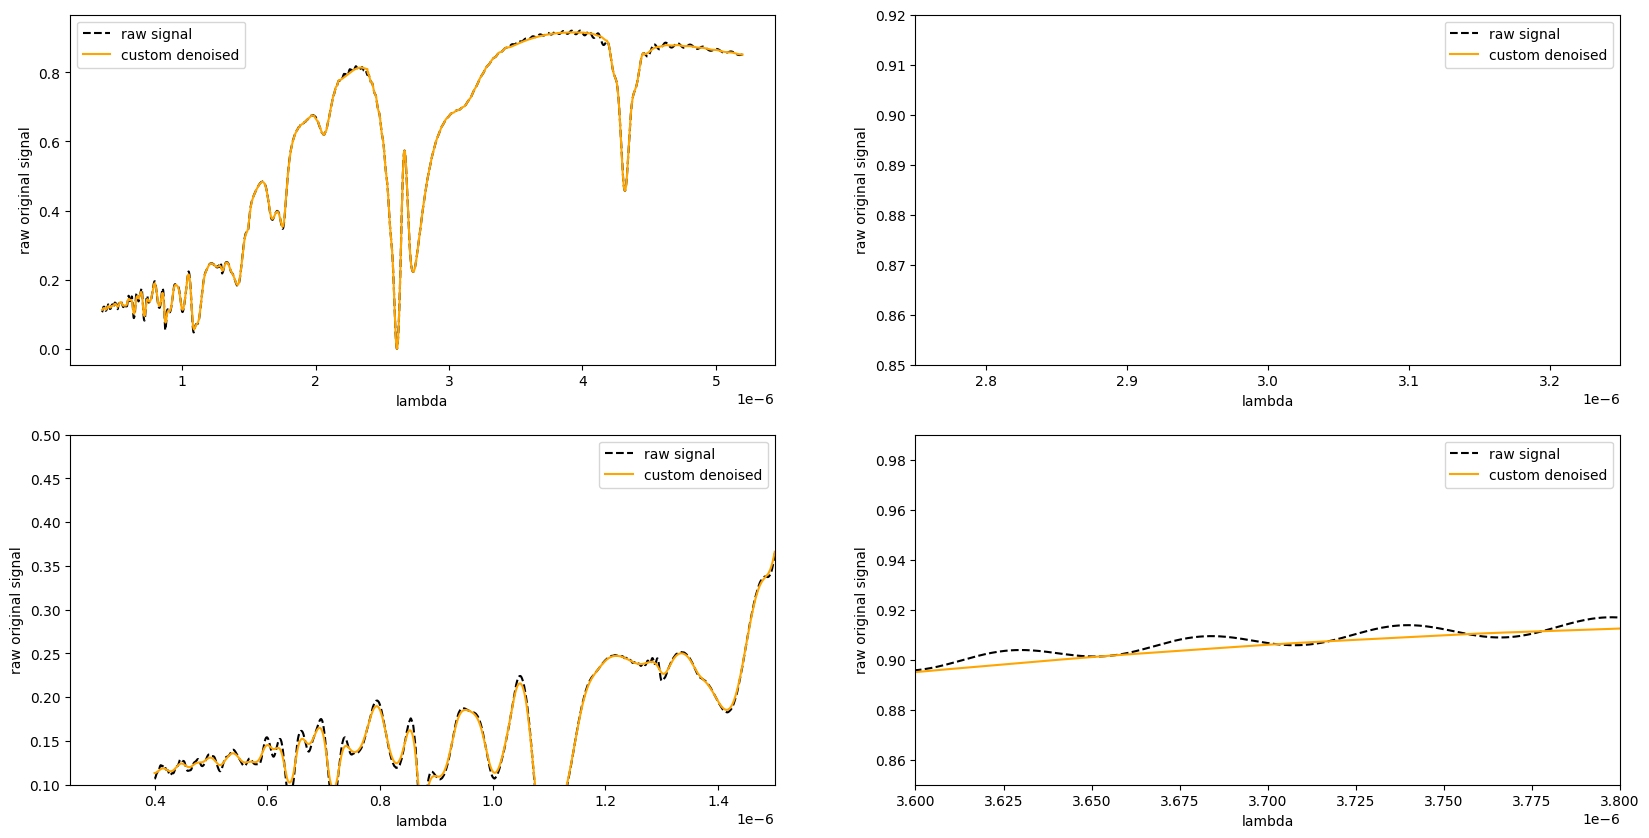

In [380]:
# create overlayed plots of the raw signal and the denoised signal
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.ravel()
alph = 0.7

for i in range(4):
    sns.lineplot(x='lambda', y='signal', data=custom_denoised2, ax=ax[i],label='raw signal',color='black',linestyle='dashed')
    sns.lineplot(x='lambda', y='smoothed_signal', data=custom_denoised2, ax=ax[i], color='orange',label='custom denoised')
    #sns.scatterplot(x='lambda', y='smoothed_signal', data=local_smoothing_patched, ax=ax[i], hue='increasing', palette='viridis')
    ax[i].set_ylabel('raw original signal')

ax[1].set_xlim(2.75e-6, 3.25e-6)
ax[1].set_ylim(0.85, 0.92)

ax[2].set_xlim(0.25e-6, 1.5e-6)
ax[2].set_ylim(0.1, 0.5)

ax[3].set_xlim(3.6e-6, 3.8e-6)
ax[3].set_ylim(0.85, 0.99)

plt.show()

# Now apply this custom denoising approach to all the other datasets

100%|██████████| 6667/6667 [00:06<00:00, 1003.35it/s]


2
{np.int64(33), np.int64(34), np.int64(3), np.int64(4)}
1574 5093


100%|██████████| 6667/6667 [00:04<00:00, 1386.20it/s]


3
{np.int64(5), np.int64(6), np.int64(41), np.int64(42), np.int64(45), np.int64(46)}
4235 2432


100%|██████████| 6667/6667 [00:05<00:00, 1195.62it/s]


3
{np.int64(5), np.int64(6), np.int64(77), np.int64(78), np.int64(61), np.int64(62)}
1525 5142


100%|██████████| 6667/6667 [00:05<00:00, 1191.10it/s]


3
{np.int64(103), np.int64(104), np.int64(141), np.int64(142), np.int64(23), np.int64(24)}
469 6198


100%|██████████| 6667/6667 [00:06<00:00, 1036.55it/s]


5
{np.int64(0), np.int64(1), np.int64(52), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(53)}
3107 3560


100%|██████████| 6667/6667 [00:05<00:00, 1184.36it/s]


5
{np.int64(39), np.int64(40), np.int64(42), np.int64(43), np.int64(45), np.int64(46), np.int64(79), np.int64(78), np.int64(54), np.int64(55)}
2958 3709


100%|██████████| 6667/6667 [00:06<00:00, 1088.32it/s]


4
{np.int64(52), np.int64(53), np.int64(55), np.int64(56), np.int64(89), np.int64(90), np.int64(125), np.int64(126)}
2938 3729


100%|██████████| 6667/6667 [00:06<00:00, 1071.90it/s]


5
{np.int64(32), np.int64(83), np.int64(84), np.int64(55), np.int64(56), np.int64(30), np.int64(31)}
3402 3265


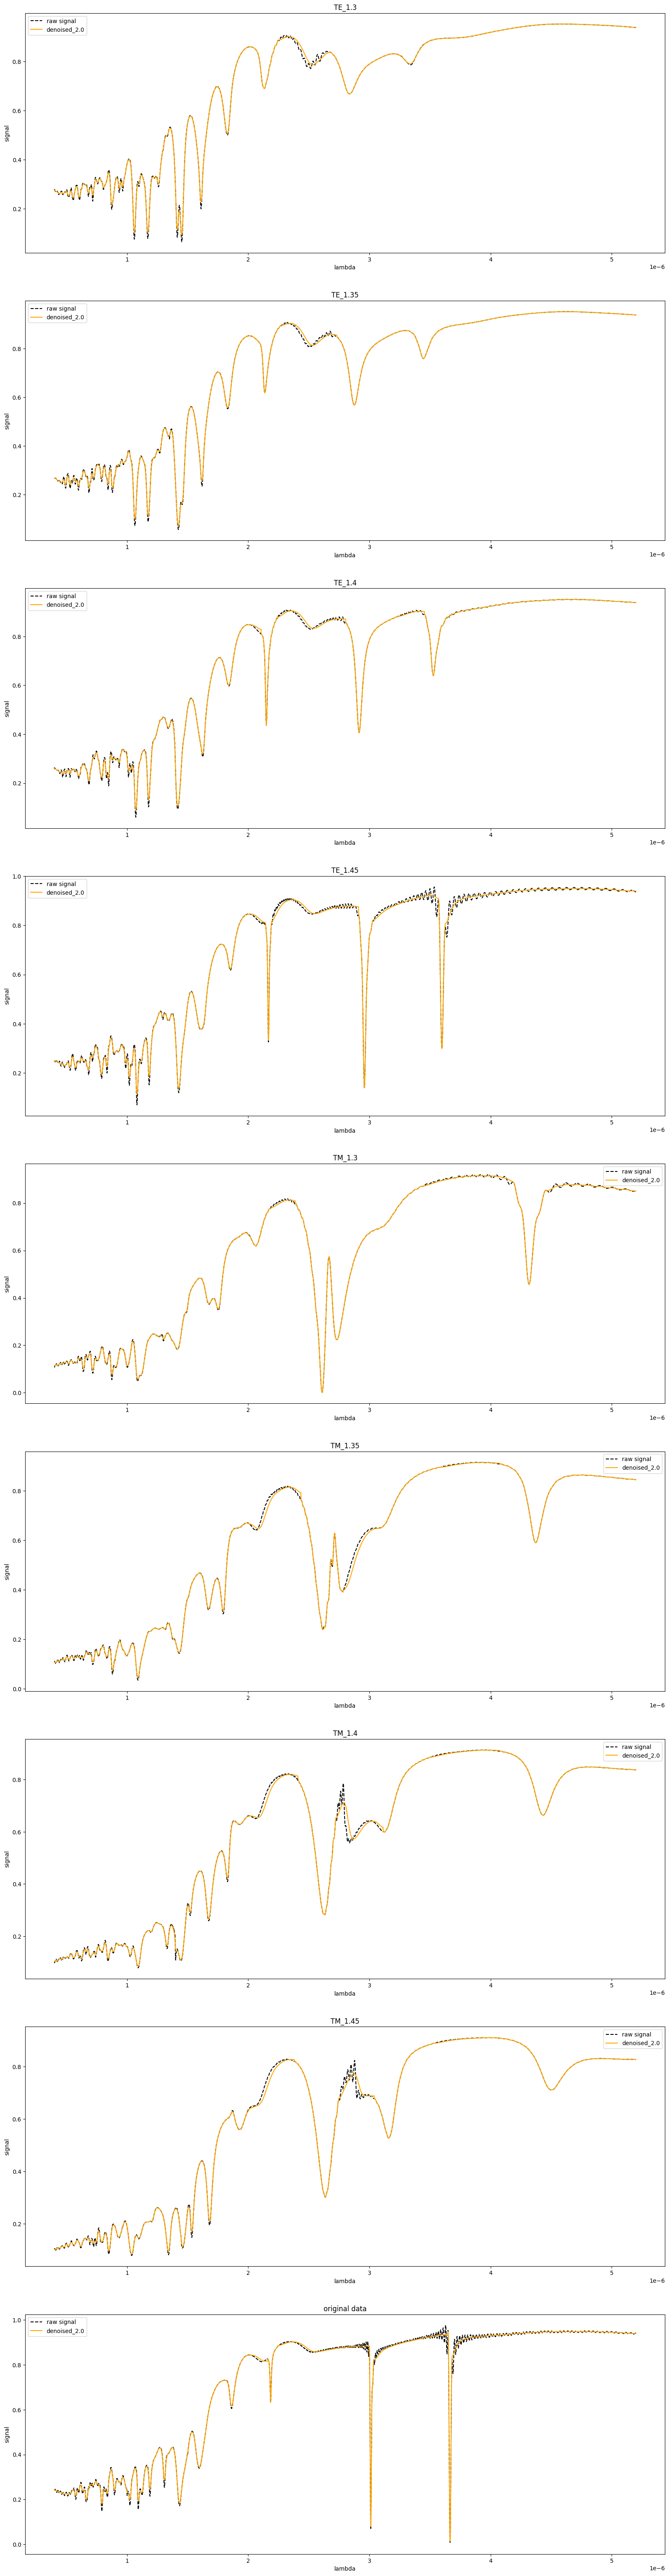

In [385]:
os.makedirs("optima_preserving_denoising", exist_ok=True)

weight = 0.5 #100.0
niter = 1000
fig,axs = plt.subplots(9,1,figsize=(20,80))
for i,suffix in enumerate(suffixes):
    sns.lineplot(x='lambda', y='signal', data=new_data[f'p2000-base1200-h2000_{suffix}'], ax=axs[i],label="raw signal",color='black',linestyle='dashed')
    temp_df = custom_denoise(new_data[f'p2000-base1200-h2000_{suffix}'])
    # apply the total variation denoising
    new_data[f'p2000-base1200-h2000_{suffix}']["optima_preserving_denoising"] = np.array(temp_df["smoothed_signal"])
    sns.lineplot(x='lambda', y=f'optima_preserving_denoising', data=new_data[f'p2000-base1200-h2000_{suffix}'], ax=axs[i],label='denoised_2.0',color='orange')
    axs[i].set_title(suffix)

    # save the data to a txt file
    new_data[f'p2000-base1200-h2000_{suffix}'].to_csv(f"optima_preserving_denoising/p2000-base1200-h2000_{suffix}_optima_preserving_denoising.txt", sep="\t", index=False)

custom_denoised.to_csv("optima_preserving_denoising/original_data_optima_preserving_denoising.txt", sep="\t", index=False)
sns.lineplot(x='lambda', y='signal', data=custom_denoised, label='raw signal',color='black',linestyle='dashed',ax=axs[8])
sns.lineplot(x='lambda', y='smoothed_signal', data=custom_denoised, label='denoised_2.0',color='orange',ax=axs[8])
axs[8].set_title('original data')

plt.show()

# save figure to svg format
fig.savefig('optima_preserving_denoising/p2000-base1200-h2000_optima_preserving_denoising.svg')

In [386]:
# now zip the optima_preserving_denoising folder
shutil.make_archive('optima_preserving_denoising', 'zip', 'optima_preserving_denoising')

'c:\\Users\\craut\\Documents\\colorimetry_ML\\code\\p03_denoising\\optima_preserving_denoising.zip'